In [21]:
import numpy as np
import pandas as pd

# reformat distmat produced by raxml
dist_file = "../otu_data/tree_data/not_full_tree/RAxML_distances.query_high_abund.distmat"
melted_dists = pd.read_csv(dist_file, sep="\t", usecols=range(2), header=None)
melted_dists.columns = ['OTUS', 'Distance']

# split first column
temp = melted_dists["OTUS"].str.split(" ", n = 1, expand = True) 
melted_dists["OTUONE"]= temp[0] 
melted_dists["OTUTWO"]= temp[1] 
melted_dists.drop(['OTUS'], inplace=True, axis=1)
melted_srs = melted_dists.set_index(['OTUONE', 'OTUTWO']).Distance
dist_df = melted_srs.unstack(level=-1)
dist_df.columns = [i.strip() for i in dist_df.columns]

# Make into a hollow symmetrical matrix
dist_df.insert(0, 'OTU1', pd.Series(index=dist_df.index))
dist_t = dist_df.T
dist_df2 = dist_t.join(pd.Series(index=dist_t.index, name='OTU9982')).T
distmat = dist_df2.values
np.fill_diagonal(distmat, 0)
dist_df3 = pd.DataFrame(distmat, index=dist_df2.index, columns=dist_df2.columns)
upper_triangle = dist_df3.fillna(0).values
symmetric_ = upper_triangle + upper_triangle.T

# write out
done_dist = pd.DataFrame(symmetric_, index=dist_df3.index, columns=dist_df3.columns)
done_dist.to_csv("../otu_data/dispersal_selection_data/not_full_tree_distances.tsv", sep="\t")


The purpose of this file is to load the ASV table, load and compare clustered sequences, check each for structural artifacts with a PCA paired with a Chi-Squared test, make some diagnostic figures, remove low frequency features, compare UNIFRAC-type and conventional distances between samples, and then make a hierarchy visualize the similarities between samples, and save the final output matrix.

#### Step 1: Load packages and OTU abundance table

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)
import yaml

# load raw abundance data 
abund_feather = '../otu_data/tree_data/hq_asv_table.feather'
abund_tsv = "../otu_data/tree_data/hq_asv_table.tsv"
if not os.path.exists(abund_feather):
    abund_df = pd.read_csv(abund_tsv, sep="\t")
    abund_df.to_feather(abund_feather)
else:
    abund_df = pd.read_feather(abund_feather, use_threads=True).set_index('Samples')
    
print("Read in abundance table with {} rows and {} columns".format(abund_df.shape[0], abund_df.shape[1]))

# load full sample sheet
config_file = "config.yml"
with open(config_file, 'r') as stream:
    cfg_dict = yaml.safe_load(stream)

data_dir = cfg_dict['data_directory']
sample_sheet_fn = cfg_dict['sample_sheet']
sample_sheet = pd.read_csv(sample_sheet_fn, sep="\t")
print("Read in metadata table with {} rows and {} columns".format(sample_sheet.shape[0], sample_sheet.shape[1]))

# Fix weird date
sample_sheet.loc[sample_sheet['DateMMDDYY'] == 'Mix9', 'DateMMDDYY'] = '100516'

# make weird samples (not mine or controls, some not in sample sheet) their own group 
weird_samples = set(abund_df.index) - set(sample_sheet.SampleID.unique())
abund_df_jm = abund_df.drop(weird_samples, axis=0)
print("After removing others' samples abundance table size is {}".format(abund_df_jm.shape))

Read in abundance table with 441 rows and 54467 columns
Read in metadata table with 413 rows and 77 columns
After removing others' samples abundance table size is (407, 54467)


#### Prep the sample sheet 

In [3]:
sample_sheet2 = sample_sheet.set_index('SampleID')
sub_sample_sheet = sample_sheet2.loc[abund_df_jm.index, :]
sub_sample_sheet.loc[sub_sample_sheet.DepthName.isnull(), 'DepthName'] = 'LAB'
sub_sample_sheet.loc[sub_sample_sheet.DepthName == 'Surface', 'DepthName'] = '1'
sub_sample_sheet.loc[sub_sample_sheet.DepthName == '0', 'DepthName'] = '1'
sub_sample_sheet.loc[[i for i in sub_sample_sheet.index if 'FiltCtrl' in i], 'StationName'] = 'CB44'
select_metadata = ['DateMMDDYY', 'StationName', 'DepthName', 'sequencing ID']

lat_lon_fn = "../otu_data/CB_Locations.tsv"
lat_lon = pd.read_csv(lat_lon_fn, sep="\t", index_col=0)
cb2lat, cb2lon = {'LAB': 00.0}, {'LAB': 00.0}

for stat_ in lat_lon.index:
    if stat_.replace(".", "") in sub_sample_sheet.StationName.unique():
        cb2lat[stat_.replace(".", "")] = round(lat_lon.loc[stat_, 'Latitude'], 3) 
        cb2lon[stat_.replace(".", "")] = round(lat_lon.loc[stat_, 'Longitude'], 3) 


sub_sample_sheet['Latitude'] = sub_sample_sheet.StationName.map(cb2lat)
sub_sample_sheet['Longitude'] = sub_sample_sheet.StationName.map(cb2lon)

read_counts = pd.read_csv("../otu_data/trim_stats/read_counts.tsv", sep="\t", header=None, index_col=0)
sub_reads = read_counts.loc[sub_sample_sheet.index, :]
sub_reads.columns = ['RawCount', 'TrimCount']

read_bins = [5e3, 1e4, 2.5e4, 5e4, 1e5, 2.5e5, 5e5, 1e6, 2.5e6]
read_discrete = pd.DataFrame(index=sub_reads.index, columns=['RawCount_b', 'TrimCount_b'],
                            data=np.zeros(sub_reads.shape))
for rb in read_bins:
    r_bool = sub_reads['RawCount'] >= rb
    read_discrete.loc[r_bool, 'RawCount_b'] += 1
    t_bool = sub_reads['TrimCount'] >= rb
    read_discrete.loc[t_bool, 'TrimCount_b'] += 1
    print("{} and {} libraries incremented".format(r_bool.sum(), t_bool.sum()))

meta_data_df = sub_sample_sheet.join(sub_reads).join(read_discrete)

md_df = meta_data_df.copy()
odu_set = set(md_df[md_df['Short sample name'].str.contains("ODU") | 
                    md_df["Sampling notes"].str.contains("ODU")].index)
dnr_set = set(md_df[md_df['Short sample name'].str.contains("DNR") | 
                    md_df["Sampling notes"].str.contains("DNR")].index)

dnr_set.update([i for i in md_df.index if 'FiltCtrl' in i])
print(len(odu_set), len(dnr_set), len(odu_set.intersection(dnr_set)))

non_pl = odu_set.union(dnr_set)
md_df_other = md_df.loc[~md_df.index.isin(non_pl), :]
possibly_pl = set(md_df_other[md_df_other.StationName == 'CB33C'].index)

print(len(possibly_pl), len(possibly_pl.intersection(odu_set)), len(possibly_pl.intersection(dnr_set)))

meta_data_df = meta_data_df.join(pd.Series(index=meta_data_df.index, name="CollectionAgency"))
meta_data_df.loc[odu_set, 'CollectionAgency'] = 'ODU'
meta_data_df.loc[dnr_set, 'CollectionAgency'] = 'DNR'
meta_data_df.loc[possibly_pl, 'CollectionAgency'] = 'Preheim'

print(meta_data_df.CollectionAgency.isnull().sum(), meta_data_df.CollectionAgency.shape)

sid_map = {'esakows1_132789': 'e_13',
           'controls': 'controls',
           'esakows1_152133_plate_1': 'e_15_1',
           'esakows1_152133_plate_2': 'e_15_2',
           'Keith_Maeve1_138650': 'KM',
           'Miseq_data_SarahPreheim_Sept2016': 'Miseq_sp',
           'sprehei1_123382': 'spr12',
           'sprehei1_149186': 'spr14'}

print(meta_data_df["sequencing ID"].unique())
meta_data_df.loc[:, 'sequencing_ID'] = meta_data_df.loc[:, 'sequencing ID'].map(sid_map)
select_metadata.remove("sequencing ID"); select_metadata.append("sequencing_ID");
print(meta_data_df.loc[:, "sequencing_ID"].unique())

control_libs = (['178A_WaterBathControlA', '178B_WaterBathControlB'])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("Blank")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("Mix9")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("CDSBBR")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("EMPTY")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("_Neg")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("ML0")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("_Pos")])
control_libs = list(set(control_libs))

meta_data_df.loc[control_libs +[i for i in meta_data_df.index if 'Filt' in i], "sequencing_ID"] = 'controls'

394 and 387 libraries incremented
390 and 375 libraries incremented
375 and 341 libraries incremented
353 and 297 libraries incremented
310 and 185 libraries incremented
154 and 31 libraries incremented
43 and 6 libraries incremented
2 and 0 libraries incremented
0 and 0 libraries incremented
119 125 0
148 0 0
15 (407,)
['esakows1_132789' 'esakows1_152133_plate_1' 'esakows1_152133_plate_2'
 'Keith_Maeve1_138650' 'Miseq_data_SarahPreheim_Sept2016'
 'sprehei1_123382' 'sprehei1_149186']
['e_13' 'e_15_1' 'e_15_2' 'KM' 'Miseq_sp' 'spr12' 'spr14']


#### Here we can see what OTUs present in control libraries are removed by different thresholds

2711 2235 2711
2290 2235 2279
3409 2711 2279
2235
index               0
control mean        0
non-control mean    0
currentMethod       0
dtype: int64


'\ng.ax_joint.collections[0].set_visible(False)\n\nfor i in to_plot.index:\n    if to_plot.loc[i, \'currentMethod\'] == 3:\n        g.ax_joint.plot(to_plot.loc[i, "control mean"], \n                        to_plot.loc[i, "non-control mean"], color=\'blue\', marker=\'o\', alpha=.6)\n    elif to_plot.loc[i, \'currentMethod\'] == 1:\n        g.ax_joint.plot(to_plot.loc[i, "control mean"], \n                        to_plot.loc[i, "non-control mean"], color=\'red\', marker=\'o\', alpha=.6)\n    elif to_plot.loc[i, \'currentMethod\'] == 0:\n        g.ax_joint.plot(to_plot.loc[i, "control mean"], \n                        to_plot.loc[i, "non-control mean"], color=\'green\', marker=\'o\', alpha=.6)\n\ng.set_axis_labels(\'log control mean\', "log non-control mean", fontsize=16)\ng.savefig("../otu_data/pca_plots/contamination_filters.png", dpi=150)\nto_plot.sort_values(by="non-control mean", ascending=False).head()\n'

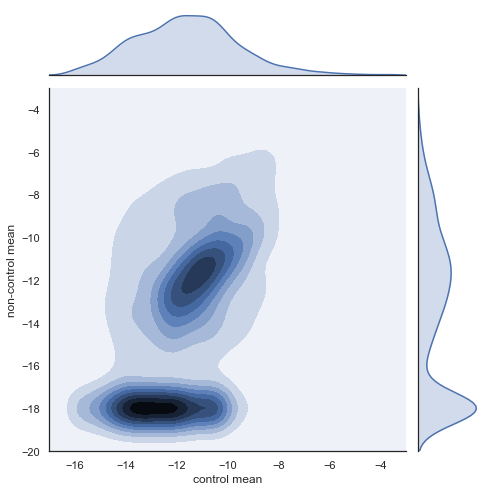

In [37]:
ctrls = control_libs
abund_table = abund_df_jm.copy()
abund_ra = abund_table.div(abund_table.sum(1), axis=0)

# 50% of relative abundance in controls
control_otus1 = abund_ra.columns[abund_ra.loc[ctrls, :].sum() > 0]
total_in_controls1 = abund_ra.loc[ctrls, control_otus1].sum()
total_in_non_controls1 = abund_ra.loc[~abund_ra.index.isin(ctrls), control_otus1].sum()
mostly_in_controls1 = control_otus1[(total_in_controls1 / total_in_non_controls1) > 0.5]
otus_to_strip1 = set(mostly_in_controls1)

# 50% of read counts in controls
control_otus2 = abund_table.columns[abund_table.loc[ctrls, :].sum() > 0]
total_in_controls2 = abund_table.loc[ctrls, control_otus2].sum()
total_in_non_controls2 = abund_table.loc[~abund_table.index.isin(ctrls), control_otus2].sum()
mostly_in_controls2 = control_otus2[(total_in_controls2 / total_in_non_controls2) > 0.5]
otus_to_strip2 = set(mostly_in_controls2)

# median relative abundance greater in controls
control_otus3 = abund_ra.columns[abund_ra.loc[ctrls, :].sum() > 0]
total_in_controls3 = abund_ra.loc[ctrls, control_otus3].apply(np.mean)
total_in_non_controls3 = abund_ra.loc[~abund_ra.index.isin(ctrls), control_otus3].apply(np.mean)
mostly_in_controls3 = control_otus3[(total_in_controls3 >= total_in_non_controls3)]
otus_to_strip3 = set(mostly_in_controls3)

oneandtwo = len(otus_to_strip1.intersection(otus_to_strip2))
oneandthree = len(otus_to_strip1.intersection(otus_to_strip3))
twoandthree = len(otus_to_strip2.intersection(otus_to_strip3))
allthree = len(otus_to_strip2.intersection(otus_to_strip3).intersection(otus_to_strip1))
print(len(otus_to_strip1), oneandtwo, oneandthree)
print(len(otus_to_strip2), oneandtwo, twoandthree)
print(len(otus_to_strip3), oneandthree, twoandthree)
print(allthree)

import seaborn as sns; import matplotlib.pyplot as plt;
sns.set(style="white", color_codes=True);
to_plot = pd.concat((np.log(total_in_controls3), np.log(total_in_non_controls3)), axis=1)
to_plot.replace([np.inf, -np.inf], np.nan).dropna(how='any', inplace=True)
to_plot.columns = ['control mean', 'non-control mean']
to_plot.loc[(to_plot['non-control mean'] == -np.inf), 'non-control mean'] = -18.0
def col_switch(x):
    if x in otus_to_strip3 and not x in otus_to_strip1:
        return 1
    elif x in otus_to_strip1 and x in otus_to_strip3:
        return 3
    elif not x in otus_to_strip1 and not x in otus_to_strip3:
        return 0

to_plot = to_plot.reset_index()
to_plot['currentMethod'] = to_plot['index'].apply(col_switch)
print(to_plot.isnull().sum())

g = sns.jointplot(x="control mean", y="non-control mean", data=to_plot, kind="kde", 
                  height=7, xlim=(-17,-3), ylim=(-20,-3))
g.savefig("../otu_data/pca_plots/contamination_filters_nc.png", dpi=150)

g.ax_joint.collections[0].set_visible(False)

for i in to_plot.index:
    if to_plot.loc[i, 'currentMethod'] == 3:
        g.ax_joint.plot(to_plot.loc[i, "control mean"], 
                        to_plot.loc[i, "non-control mean"], color='blue', marker='o', alpha=.6)
    elif to_plot.loc[i, 'currentMethod'] == 1:
        g.ax_joint.plot(to_plot.loc[i, "control mean"], 
                        to_plot.loc[i, "non-control mean"], color='red', marker='o', alpha=.6)
    elif to_plot.loc[i, 'currentMethod'] == 0:
        g.ax_joint.plot(to_plot.loc[i, "control mean"], 
                        to_plot.loc[i, "non-control mean"], color='green', marker='o', alpha=.6)

g.set_axis_labels('log control mean', "log non-control mean", fontsize=16)
g.savefig("../otu_data/pca_plots/contamination_filters.png", dpi=150)
to_plot.sort_values(by="non-control mean", ascending=False).head()


#### Here we will define a function that drops features present mostly in controls and samples with low yields

In [5]:
def decrease_sparsity(abund_table, ctrls, abund_thresh=0.002, div_thresh=100, rare_thresh=3000, addl_keys=[]):
    """Takes an abundance table and a list of control indexes
       Removes OTUs with 50% or more of their abundances in controls.
       Removes OTUS below user set abundances threshold.
       Removes features below rarefaction threshold.
       Removes additional features according to string matched key"""
    otus_to_strip = set()
    abund_ra = abund_table.div(abund_table.sum(1), axis=0)
    control_otus = abund_ra.columns[abund_ra.loc[ctrls, :].sum() > 0]
    total_in_controls = abund_ra.loc[ctrls, control_otus].apply(np.mean)
    total_in_non_controls = abund_ra.loc[~abund_ra.index.isin(ctrls), control_otus].apply(np.mean)
    mostly_in_controls = control_otus[(total_in_controls >= total_in_non_controls)]
    otus_to_strip.update(mostly_in_controls)
    print("{} are to be removed as contaminants".format(len(otus_to_strip)))
    low_abund = abund_table.columns[(abund_ra > abund_thresh).sum() == 0]
    otus_to_strip.update(low_abund)
    print("{} are to be removed after adding low abundance OTUs".format(len(otus_to_strip)))
    presence_absence = ((abund_table > 0))
    infrequent_appearances = abund_table.columns[presence_absence.sum() < 2]
    otus_to_strip.update(infrequent_appearances)
    print("{} are to be removed after adding low freq OTUs".format(len(otus_to_strip)))
    div_samples = presence_absence.sum(1)
    print("Removing samples with fewer features than Zymo ({})".format(div_thresh))
    abund_to_return = abund_table.copy()
    for ak in addl_keys: 
        ctrls += list(abund_table.index[abund_table.index.str.contains(ak)])
    
    ctrls += list(abund_table.index[div_samples < div_thresh])
    ctrls += list(abund_table.index[abund_to_return.sum(1) < rare_thresh])
    
    fmt_libs = "".join(["\t"+cl+"\n" for cl in set(ctrls)])
    print("Removed libraries are:\n{}".format(fmt_libs))
        
    abund_to_return = abund_to_return.loc[~(abund_table.index.isin(ctrls)), 
                                          ~abund_table.columns.isin(otus_to_strip)]
    
    print("{}, {} are shapes after bad otus and low yeild samples".format(abund_table.shape, abund_to_return.shape))
    return abund_to_return

print("Decreasing sparsity of full table:")
abund_df_og_s1 = decrease_sparsity(abund_df_jm.copy(), control_libs, abund_thresh=0.002, addl_keys=['Zymo'])

Decreasing sparsity of full table:
3469 are to be removed as contaminants
52872 are to be removed after adding low abundance OTUs
52905 are to be removed after adding low freq OTUs
Removing samples with fewer features than Zymo (100)
Removed libraries are:
	SB091817TAWCSCB73D12BR1TR1I512
	SB061815TAWCSCB33CD10BR2TR1I14
	SB082916TAWCSCB71D20BR1TR1I239
	SB062716TAWCSLABDPCBR1TR1I602
	SB061815TAWCSCB33CD16BR1TR1I20
	SB071017TAWCSCB62D9BR1TR1I414
	SB062917TAWCSLABDPCBR1TR3I608
	SB061815TAWCSCB33CD3BR1TR1I6
	SB082015TAWCSCB33CD0BR1TR1I51
	SB072215TAWCSCB33CD22BR1TR1I46
	SB082015TAWCSCB33CDSBBR1TR1I50
	92_Mix93_Control_R2
	SB072215TAWCSCB33CD14BR1TR1I42
	SB092616TAWCSLABDNABR1TR1I268
	SB072516TAWCSCB33CDSBBR1TR1I125
	SB072215TAWCSCB33CDSBBR1TR1I26
	SB092116TAWCSLABDNCBR1TR1I247
	SB062917TAWCSLABDPCBR1TR1I607
	SB082015TAWCSCB33CD21BR1TR1I75
	SB062716TAWCSCB33CD20BR1TR1I91
	SB091817TAWCSCB54D25BR2TR1I515
	96_ZymoControl_R1
	SBMix9TAWCSLABDPCBR1TR2I270
	SB071116TAWCSCB41CD31BR1TR1I149
	SB081216

#### More metadata prep work 

In [6]:
super_df = pd.concat([abund_df_og_s1, meta_data_df.loc[abund_df_og_s1.index, :]], axis=1)
super_df.DepthName = super_df.DepthName.apply(lambda x: "0"+x if len(x) == 1 else x)
super_df['Month'] = super_df.DateMMDDYY.apply(lambda x: x[:2])
super_df['Year'] = super_df.DateMMDDYY.apply(lambda x: x[-2:])
super_df['Month_Year'] = super_df.loc[:, ['Month', 'Year']].apply(lambda x: " ".join(x), axis=1)
sort_vars = ['Year', 'Month', 'Latitude', 'DepthName']
super_df.sort_values(sort_vars, ascending=[True, True, False, True], inplace=True)
super_df['Salinity_Group'] = pd.Series([""]*super_df.index.shape[0], index=super_df.index)
some_indexes = super_df.index[[0,1,2,100,101,102,200,201,202,-3,-2,-1]]
some_columns = ['DepthName', 'Month', 'Year', 'Month_Year', 'CollectionAgency', 'Salinity_Group', 'sequencing_ID']
super_df.loc[some_indexes, some_columns]

DepthName Month Year Month_Year  \
Samples                                                          
SB061815TAWCSCB33CD0BR1TR1I3          01    06   15      06 15   
SB061815TAWCSCB33CD1BR1TR1I4          01    06   15      06 15   
SB061815TAWCSCB33CD2BR1TR1I5          02    06   15      06 15   
SB071116TAWCSCB72D20BR1TR1I169        20    07   16      07 16   
SB071116TAWCSCB64D10BR1TR1I165        10    07   16      07 16   
SB071116TAWCSCB74D13BR2TR1I173        13    07   16      07 16   
SB050817TAWCSCB61D11BR1TR1I336        01    05   17      05 17   
SB050817TAWCSCB61D11BR1TR1I345        11    05   17      05 17   
SB050817TAWCSCB62D9BR1TR1I337         01    05   17      05 17   
SB091817TAWCSCB63D10BR1TR1I518        10    09   17      09 17   
SB091817TAWCSCB72D20BR1TR1I521        20    09   17      09 17   
SB091817TAWCSCB73D12BR1TR1I522        12    09   17      09 17   

                               CollectionAgency Salinity_Group sequencing_ID  
Samples                                                                       
SB061815TAWCSCB33CD0BR1TR1I3            Preheim                        spr12  
SB061815TAWCSCB33CD1BR1TR1I4            Preheim                        spr12  
SB061815TAWCSCB33CD2BR1TR1I5            Preheim                        spr12  
SB071116TAWCSCB72D20BR1TR1I169              ODU                           KM  
SB071116TAWCSCB64D10BR1TR1I165              ODU                           KM  
SB071116TAWCSCB74D13BR2TR1I173              ODU                           KM  
SB050817TAWCSCB61D11BR1TR1I336              ODU                       e_15_2  
SB050817TAWCSCB61D11BR1TR1I345              ODU                       e_15_1  
SB050817TAWCSCB62D9BR1TR1I337               ODU                       e_15_1  
SB091817TAWCSCB63D10BR1TR1I518              ODU                       e_15_2  
SB091817TAWCSCB72D20BR1TR1I521              ODU                       e_15_2  
SB091817TAWCSCB73D12BR1TR1I522              ODU                        spr14

#### Write out a table of dates, depths, and stations for collaborators

In [7]:
true_surf = [i for i in super_df.index if 'CD0BR' in i]
super_df.loc[true_surf, 'DepthName'] = '00'
some_columns = ['DepthName', 'DateMMDDYY', 'Month', 'Year', 'StationName', 'CollectionAgency']
to_remove = super_df.DepthName.isin(['LAB', 'lab'])
subdf = super_df.loc[~to_remove, some_columns].drop_duplicates()
subdf.to_csv("../otu_data/Preheim_CB_DepthStationYear.tab", sep="\t")

#### Import taxa table and print some random rows to take a look

In [8]:
taxa_file = "taxa_table.tsv"
data_path = "../otu_data/dada2_outputs"
tax_f = os.path.join(data_path, taxa_file)
taxa_df = pd.read_csv(tax_f, sep="\t")
OTU_Seqs = {taxa_df.loc[idx, taxa_df.columns[0]]:idx for idx in taxa_df.index}
OTU_Names = {idx:"OTU{}".format(idx+1) for idx in taxa_df.index }
OTU_name2seq = {OTU_Names[num]:seq for seq, num in OTU_Seqs.items()}
taxa_df.loc[:, taxa_df.columns[0]] = taxa_df.loc[:, taxa_df.columns[0]].apply(lambda x: OTU_Names[OTU_Seqs[x]])
taxa_df = taxa_df.set_index(taxa_df.columns[0])
taxa_df.loc[['OTU2880', 'OTU14561', 'OTU38271', "OTU54666", 'OTU15257', 'OTU30263', 'OTU2'], :]

Kingdom           Phylum                Class  \
Unnamed: 0                                                   
OTU2880      Archaea              NaN                  NaN   
OTU14561     Archaea              NaN                  NaN   
OTU38271     Archaea              NaN                  NaN   
OTU54666     Archaea  Nanoarchaeaeota        Woesearchaeia   
OTU15257    Bacteria   Proteobacteria  Gammaproteobacteria   
OTU30263    Bacteria   Proteobacteria  Gammaproteobacteria   
OTU2        Bacteria   Proteobacteria  Gammaproteobacteria   

                            Order                  Family Genus Species  
Unnamed: 0                                                               
OTU2880                       NaN                     NaN   NaN     NaN  
OTU14561                      NaN                     NaN   NaN     NaN  
OTU38271                      NaN                     NaN   NaN     NaN  
OTU54666                      NaN                     NaN   NaN     NaN  
OTU15257    Ectothiorhodospirales  Ectothiorhodospiraceae   NaN     NaN  
OTU30263    Ectothiorhodospirales  Ectothiorhodospiraceae   NaN     NaN  
OTU2        Ectothiorhodospirales  Ectothiorhodospiraceae   NaN     NaN

#### This is where we rarefy to 3001 total counts and look at the results

Abundance Thresholded
Big samples: 18, Small: 33
0.6726840850682114 BvB
0.9778816199376947 SvS
0.9875414880324958 BvS
0.6812729090303232 BvB
0.9526824391869377 SvS
0.8348883705431522 BvS


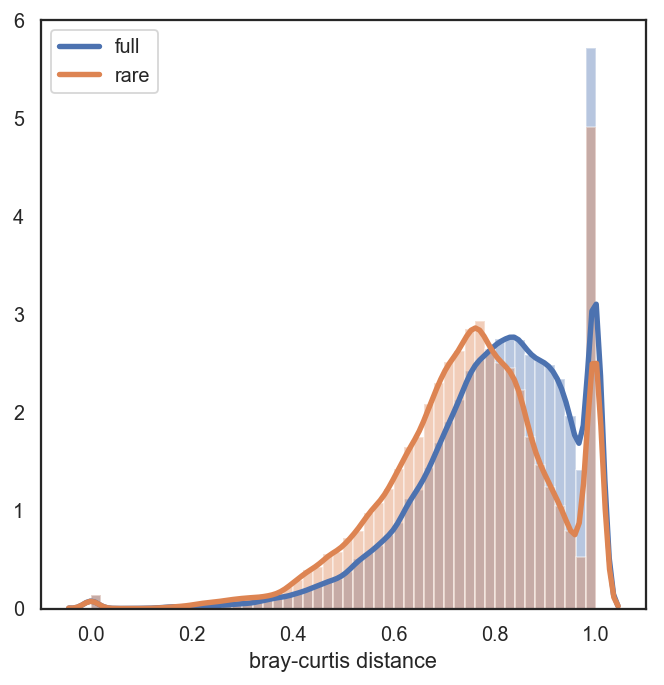

Abundance Thresholded full Abundance Thresholded rare
0.8231759792957754 0.001 362


In [38]:
from skbio.stats import subsample_counts
from skbio.diversity import beta_diversity
import seaborn as sns
from skbio.stats.distance import mantel

def rarefy_table(abund_table, rare_level):
    rare_abund = abund_table.copy() * 0.
    total_abunds = abund_table.sum(1)
    for samp in abund_table.index:
        norm_factor = 1.0
        if total_abunds[samp] < rare_level:
            norm_factor = rare_level / total_abunds[samp]

        select_vect = np.ceil(abund_table.loc[samp, :].values*norm_factor).astype(np.int64)
        rare_vect = subsample_counts(select_vect, int(rare_level))
        rare_abund.loc[samp, :] = rare_vect
    return rare_abund

disttabs = {}
abundance_tables = {'Abundance Thresholded':abund_df_og_s1.copy()}
for name_ab, ab_df in abundance_tables.items():
    rare_pp = rarefy_table(ab_df, 3001)
    sample_sums = ab_df.sum(1)
    big_samples = ab_df[sample_sums > 300000].index
    smaller_samples = ab_df[sample_sums < 10000].index
    print(name_ab)
    print("Big samples: {}, Small: {}".format(len(big_samples), len(smaller_samples)))
    plt.clf(); plt.close();
    fixx, axx = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=130)
    cols = ['gold', 'teal']
    labs = ['full', 'rare']
    for ixx, a_table in enumerate([ab_df, rare_pp]):
        bc_dists = beta_diversity("braycurtis", a_table.values, a_table.index)
        disttabs[name_ab + " " + labs[ixx]] = bc_dists
        bc_df = pd.DataFrame(index=a_table.index, columns=a_table.index, data=bc_dists._data)
        print(np.median(bc_df.loc[big_samples, big_samples]), "BvB")
        print(np.median(bc_df.loc[smaller_samples, smaller_samples]), "SvS")
        print(np.median(bc_df.loc[big_samples, smaller_samples]), "BvS")
        sns.distplot(bc_df.values.flatten(), axlabel='bray-curtis distance',
                     kde_kws={"label":labs[ixx], "lw": 3}, ax=axx)
    fixx.savefig("../otu_data/trim_stats/rarefaction_effect.png")
    plt.show()

all_mat_names = list(disttabs.keys())
for ix in range(len(all_mat_names)):
    for jx in range(ix+1, len(all_mat_names)):
        print(all_mat_names[ix], all_mat_names[jx])
        r_pp, p_value_pp, n_pp = mantel(disttabs[all_mat_names[ix]], disttabs[all_mat_names[jx]], method='pearson')
        print(r_pp, p_value_pp, n_pp)

#### Write out sequences to make a tree. This is commended out because it was done and should not be redone.

In [10]:
#out_path = "../otu_data/tree_data"
#fnames = ['query_high_abund002.fasta', 'query_high_abund0005.fasta']
#abund_df_ogs = [abund_df_og_s1 ]#, abund_df_og_p1]
#for fname, abund_df_og in zip(fnames, abund_df_ogs):
#    heads = sorted(list(abund_df_og.columns))
#    tails = [OTU_name2seq[i] for i in heads]
#    with open(os.path.join(out_path, fname), "w") as wofh:
#        print(wofh.write("".join([">{}\n{}\n".format(i, j) for i, j in zip(heads, tails)])))


#### This calculates the inter-run distances, plots their pdfs, and performs Mann-Whitney U test on each pairing 

spr12 (14805, 1) (47, 315)
e_13 (8736, 1) (26, 336)
KM (24297, 1) (89, 273)
Miseq_sp (4200, 1) (12, 350)
e_15_1 (23925, 1) (87, 275)
e_15_2 (18600, 1) (62, 300)
spr14 (12312, 1) (38, 324)
controls (361, 1) (1, 361)


<Figure size 432x288 with 0 Axes>

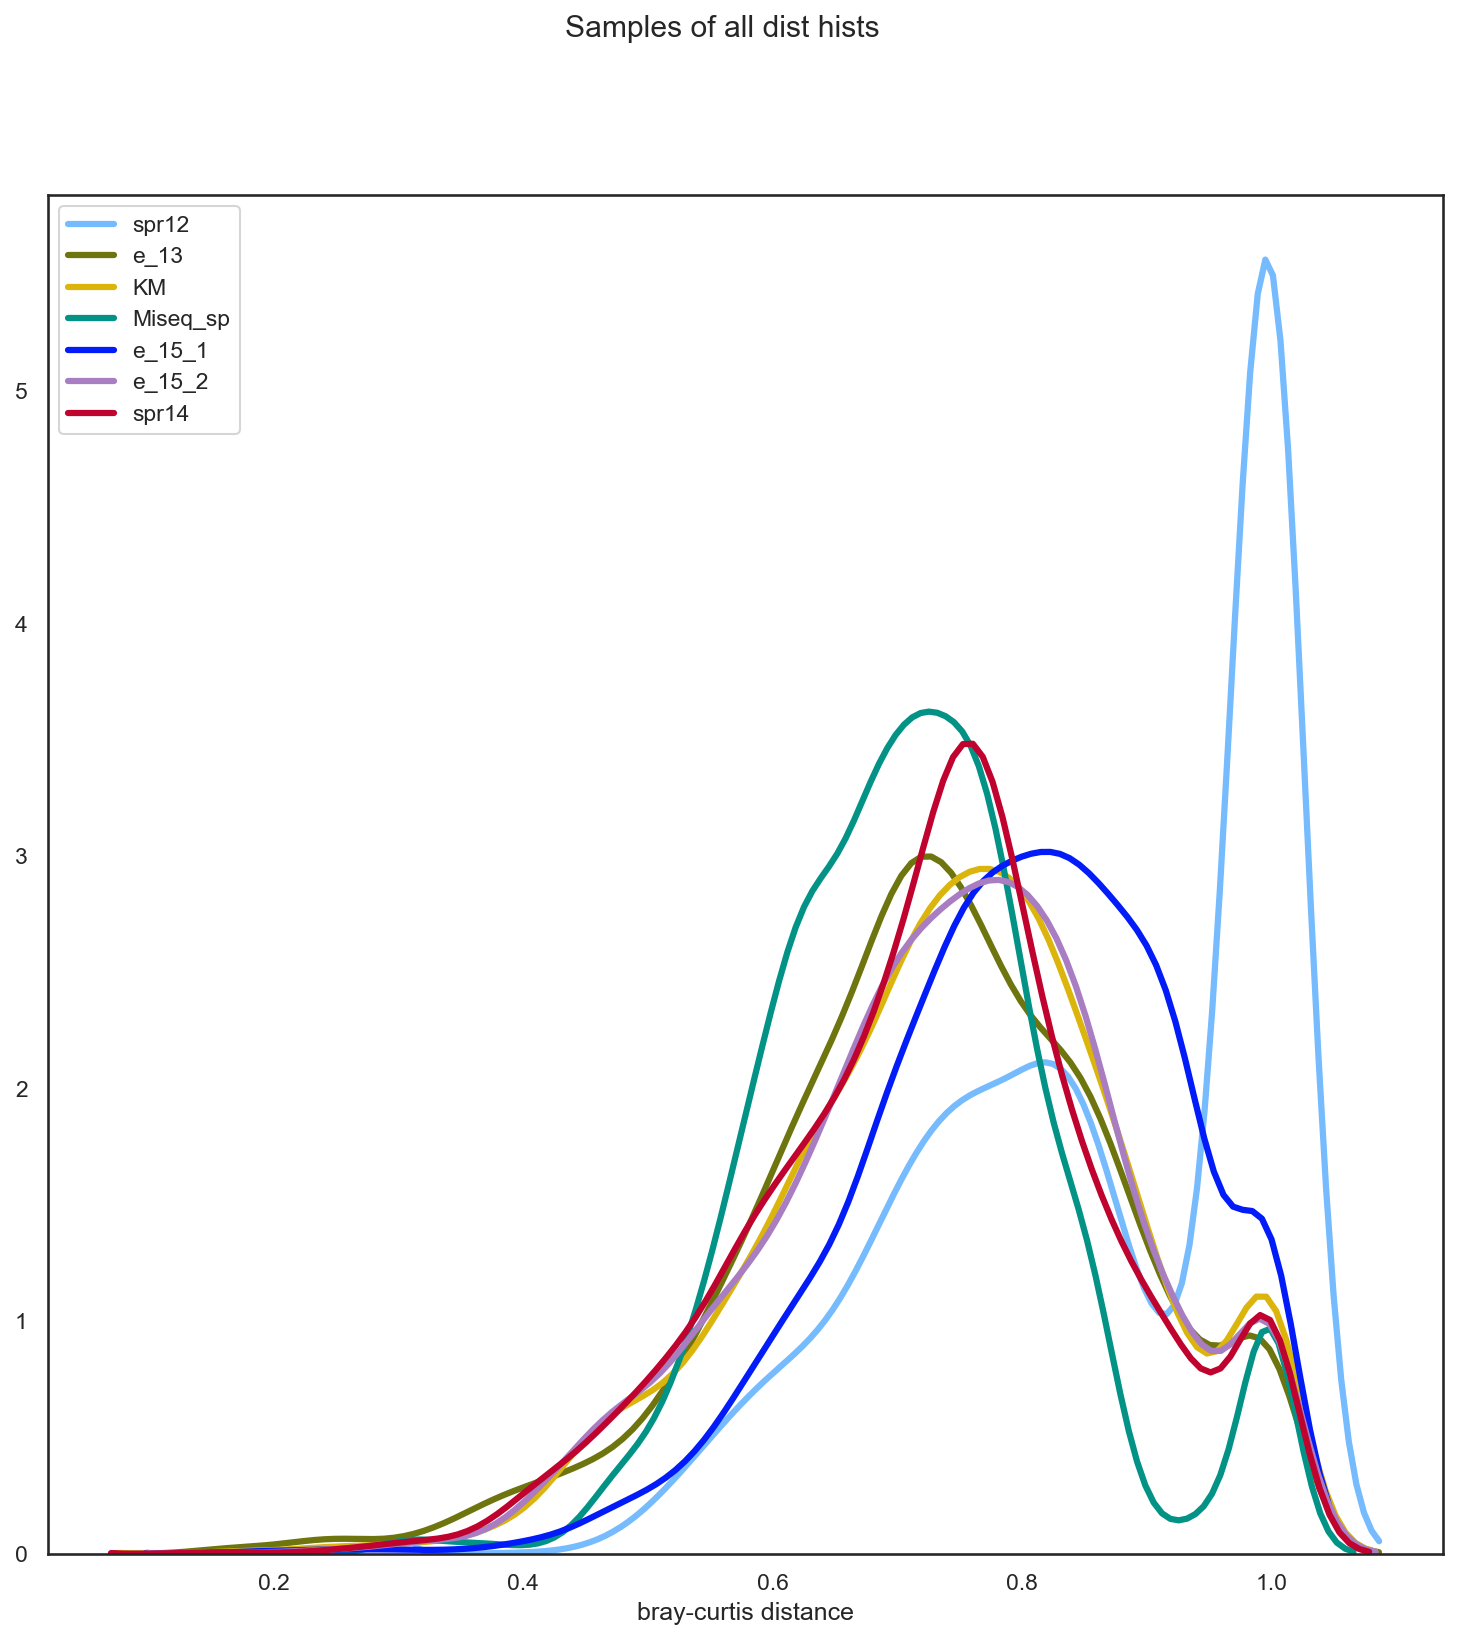

Significance level is 0.0011904761904761906


spr12   e_13     KM  Miseq_sp  e_15_1  e_15_2  spr14
spr12     False   True   True      True    True    True   True
e_13       True  False   True      True    True    True  False
KM         True   True  False      True    True   False   True
Miseq_sp   True   True   True     False    True    True   True
e_15_1     True   True   True      True   False    True   True
e_15_2     True   True  False      True    True   False   True
spr14      True  False   True      True    True    True  False

In [11]:
import seaborn as sns

groups = list(super_df['sequencing_ID'].unique())

def calculate_group_distance(a_label, a_table):
    # subset according to "in" label 
    in_indexes = super_df[super_df['sequencing_ID'] == a_label].index
    
    # subset according to "out" label
    out_group = set(groups) - set([a_label]) 
    out_indexes = super_df[super_df['sequencing_ID'].isin(out_group)].index
    assert len(out_indexes) + len(in_indexes) == len(a_table.index)
    
    # calculate bray-curtis for all groups
    bc_dists = beta_diversity("braycurtis", a_table.values, a_table.index)
    bc_df = pd.DataFrame(bc_dists._data, index=a_table.index, columns=a_table.index)
    
    # subset rows by "in" and columns by "out" 
    sub_bcdf = bc_df.loc[in_indexes, out_indexes]
    if sub_bcdf.shape[0] == 1:
        flat_df = sub_bcdf.T
        flat_df.columns = [a_label]
    else:
        flat_df = pd.DataFrame(sub_bcdf.values.flatten(), columns=[a_label])
        
    print(a_label, flat_df.shape, sub_bcdf.shape)
    return (flat_df, flat_df[a_label].mean())

out_data = {}
for a_label in groups:
    out_data[a_label] = calculate_group_distance(a_label, rare_pp.copy())

_ = out_data.pop('controls'); groups.remove('controls'); 

flat_dfs = pd.DataFrame({l:fdf[l].sample(4000).values for l, (fdf, m) in out_data.items()})

# calculate average distance 

color_choices = ["sky blue", "olive", "gold", "teal", "rich blue", "wisteria", "lipstick red"]

plt.clf()
f, _axes_ = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=150)
f.suptitle("Samples of all dist hists")
for a_label, cc in zip(groups, color_choices):
    sns.distplot(flat_dfs[a_label], hist=False, axlabel='bray-curtis distance',
                 kde_kws={"label":a_label, 
                          "lw": 3, 
                          "color": sns.xkcd_rgb[cc]}, 
                 ax=_axes_)

plt.legend()
plt.savefig("../otu_data/pca_plots/cross_dists_abthrsh.png", bbox_inches='tight')
plt.show()
plt.clf()
plt.close()

from scipy.stats import mannwhitneyu

pair_tests = pd.DataFrame(index=groups, columns=groups)
for ix in pair_tests.index:
    for cx in pair_tests.columns:
        result = mannwhitneyu(flat_dfs.loc[:, cx].values, flat_dfs.loc[:, ix].values)
        pair_tests.loc[ix, cx] = result[1]*2

sig_level = 0.05/(7*6)
print("Significance level is {}".format(sig_level))
pair_tests < sig_level


#### This creates a plot to show how many OTUs are shared across sequencing runs from the main station (CB33C)

(143, 1562) (143, 88) ['spr12', 'e_13', 'KM', 'Miseq_sp', 'e_15_1', 'e_15_2', 'spr14']
spr12 has 47 libraries
e_13 has 13 libraries
KM has 38 libraries
Miseq_sp has 12 libraries
e_15_1 has 9 libraries
e_15_2 has 12 libraries
spr14 has 12 libraries
337 otus shared across all runs


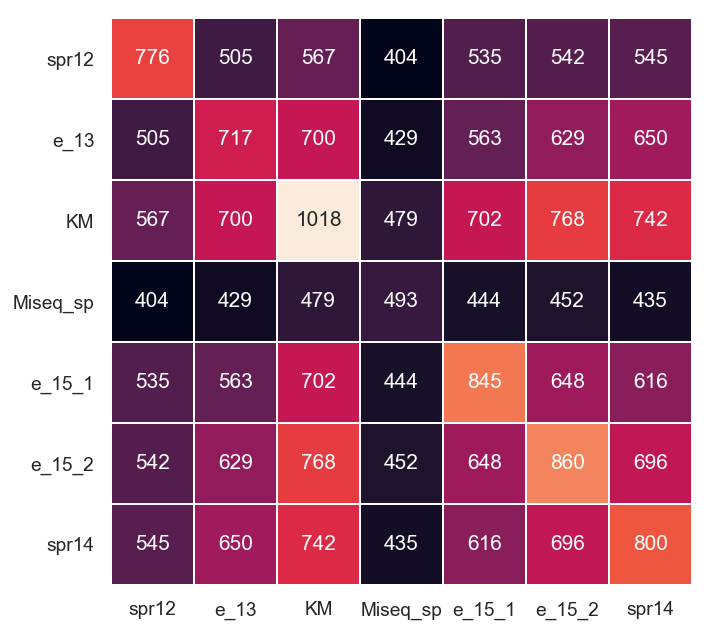

In [18]:
onlycb33 = super_df['StationName'] == 'CB33C'
adf = rare_pp.loc[onlycb33, :]
mdf = super_df.loc[onlycb33, ~super_df.columns.isin(abund_df_og_s1.columns)]
runs_to_keep = list(super_df['sequencing_ID'].unique())
if 'controls' in runs_to_keep:
    runs_to_keep.remove('controls')
print(adf.shape, mdf.shape, runs_to_keep)
shared_otus = pd.DataFrame(index=runs_to_keep, columns=runs_to_keep)
shared_group = set(adf.columns)

for run_grp1 in shared_otus.columns:
    rg1_bool = mdf.sequencing_ID == run_grp1
    print("{} has {} libraries".format(run_grp1, rg1_bool.sum()))
    for run_grp2 in shared_otus.index:
        rg2_bool = mdf.sequencing_ID == run_grp2
        otus_in_1 = adf.loc[rg1_bool, :].sum() / rg1_bool.sum()
        otus_in_2 = adf.loc[rg2_bool, :].sum() / rg2_bool.sum()
        foldchange = otus_in_1 / otus_in_2
        num_shared = ((foldchange < 1000) & (foldchange > 0.001)).sum()
        shared_otus.loc[run_grp2, run_grp1] = num_shared
        # optional shared across all groups
        shared_here = foldchange.index[(foldchange < 1000) & (foldchange > 0.001)]
        shared_group = shared_group.intersection(set(shared_here))

print("{} otus shared across all runs".format(len(shared_group)))


plt.clf(); plt.close();
f, _axes_ = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=125)
sns.heatmap(shared_otus, annot=True, annot_kws={'fontsize':12}, fmt="d", linewidths=.5, ax=_axes_, cbar=False)
plt.savefig("../otu_data/OTU_Overlap_CB33_byRun_abthrsh.png", bbox_inches='tight')
plt.show()
plt.clf(); plt.close();


#### Add Alpha and Beta-Diversity Distances to Columns

In [13]:
from skbio import TreeNode
from io import StringIO
from skbio.diversity import alpha_diversity
import skbio.stats.composition as ssc 
from deicode.preprocessing import rclr
from scipy.spatial.distance import pdist, squareform

rare_fn = "../otu_data/final_rarefied_table.tsv"
meta_fn = "../otu_data/final_metadata.tsv"
if os.path.exists(rare_fn) and os.path.exists(meta_fn):
    meta_df_x = pd.read_csv(meta_fn, sep="\t", index_col=0)
    rare_abund = pd.read_csv(rare_fn, sep="\t", index_col=0)
    print(rare_abund.shape, meta_df_x.shape)
else:
    tree_file = "../otu_data/tree_data/not_full_tree/RAxML_rootedTree.root.query_high_abund.ref.tre"
    with open(tree_file, 'r') as tfh:
        tree_str = tfh.read().strip()

    tree_obj = TreeNode.read(StringIO(tree_str))

    rare_pp_nz = rare_pp.loc[:, rare_pp.columns[rare_pp.sum() > 0]]
    

    print("Dropped {} empty columns".format(rare_pp.shape[1] - rare_pp_nz.shape[1]))
    print("Calculating Beta Diversity")
    wu_dm = beta_diversity("weighted_unifrac", rare_pp_nz.values, 
                           list(rare_pp_nz.index), tree=tree_obj, 
                           otu_ids=list(rare_pp_nz.columns))._data
    print("Finished unifrac", wu_dm.shape)

    bc_dm = beta_diversity("braycurtis", rare_pp_nz.values, rare_pp_nz.index)._data
    print("Finished bray curtis", bc_dm.shape)

    # clr transform
    close_mat = ssc.closure(rare_pp_nz.values)
    nz_mat = ssc.multiplicative_replacement(close_mat)
    rclr_mat = rclr().fit_transform(nz_mat)
    clr_dm = squareform(pdist(rclr_mat, 'euclidean'))
    print("Finished clr+euclidean", clr_dm.shape)

    # put it all together 
    beta_mats = []
    for suff, mat in zip(['_wu', '_bc', '_clr'], [wu_dm, bc_dm, clr_dm]):
        new_cols = [i+suff for i in list(rare_pp_nz.index)]
        dm_df = pd.DataFrame(mat, index=rare_pp_nz.index, columns=new_cols)
        beta_mats.append(dm_df.copy())

    super_beta = beta_mats[0].join(beta_mats[1]).join(beta_mats[2])
    print(super_beta.shape)
    
    print("Calculating alpha diversity metrics and rarefaction table")
    alpha_cols = ['enspie', 'enspie_25', 'enspie_975', 
                  'observed_otus', 'observed_otus_25', 'observed_otus_975',
                  'faith_pd', 'faith_pd_25', 'faith_pd_975']
    
    total_abunds = abund_df_og_s1.sum(1)
    rare_level = 3001
    bstrap_cnt = 100
    enspies_bsts = pd.DataFrame(index=abund_df_og_s1.index, 
                                columns=range(bstrap_cnt)).astype(float)
    obs_otuses_bsts = pd.DataFrame(index=abund_df_og_s1.index, 
                                   columns=range(bstrap_cnt)).astype(float)
    faith_pd_bsts = pd.DataFrame(index=abund_df_og_s1.index, 
                                 columns=range(bstrap_cnt)).astype(float)
    for r_ix in range(bstrap_cnt):
        rare_table = rarefy_table(abund_df_og_s1.copy(), rare_level)
        faith_pd_bsts.loc[:, r_ix] = alpha_diversity('faith_pd', rare_table.values, ids=list(rare_table.index), 
                                                     otu_ids=list(rare_table.columns), tree=tree_obj)
        obs_otuses_bsts.loc[:, r_ix] = alpha_diversity('observed_otus', 
                                                       rare_table.values, 
                                                       list(rare_table.index))
        enspies_bsts.loc[:, r_ix] = alpha_diversity('enspie', rare_table.values, list(rare_table.index))
        print("Alpha calcs completion percent {:.2%}".format((r_ix+1)/bstrap_cnt), sep=' ', end="\r", flush=True)
    
    alpha_metrics = pd.DataFrame(index=abund_df_og_s1.index, columns=alpha_cols).astype(float)
    alpha_iterator = zip(['enspie', "observed_otus", 'faith_pd'], [enspies_bsts, obs_otuses_bsts, faith_pd_bsts])
    pct_fxn = lambda x: np.percentile(x, [2.5, 50, 97.5])
    for met_name, met_df in alpha_iterator:
        met_srs = met_df.apply(pct_fxn, axis=1)
        alpha_metrics.loc[met_srs.index, met_name] = met_srs.apply(lambda x: x[1])
        alpha_metrics.loc[met_srs.index, met_name+'_25'] = met_srs.apply(lambda x: x[1] - x[0]) 
        alpha_metrics.loc[met_srs.index, met_name+'_975'] = met_srs.apply(lambda x: x[2] - x[1])
    
    m_data_cols_ = set(super_df.columns) - set(abund_df_og_s1.columns)
    print(alpha_metrics.shape, super_beta.shape, )
    meta_df_x = super_df.loc[:, m_data_cols_].join(alpha_metrics).join(super_beta)
    rare_abund = rare_pp_nz.copy()
    meta_df_x.to_csv(meta_fn, sep="\t")
    rare_abund.to_csv(rare_fn, sep="\t")
    print("Writing rarefied counts ({1}) and metadata ({0}) to file".format(rare_abund.shape, meta_df_x.shape))


(362, 1561) (362, 1183)


# add all the rest of the sample data

44 potential replicates


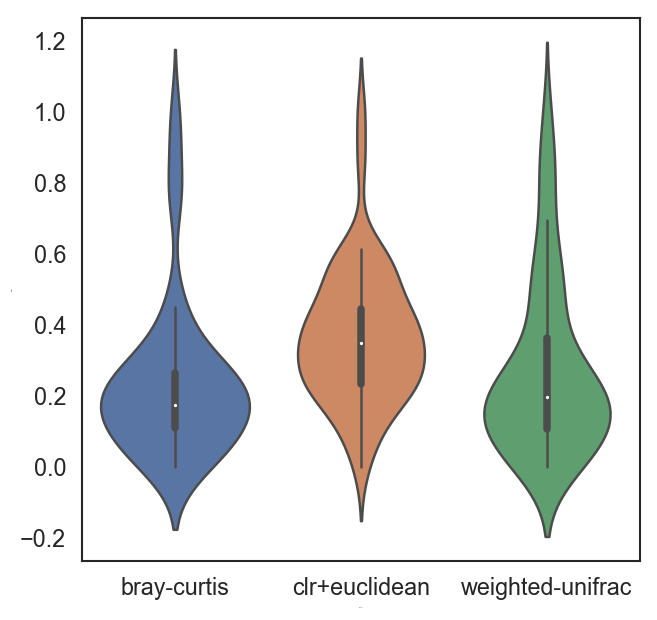

(314, 2746) (362, 2746) (291, 2)


In [42]:
# fix some station mislabellings back 
abund_md_df = rare_abund.join(meta_df_x)
true_surf = [i for i in abund_md_df.index if 'CD0BR' in i]

abund_md_df.loc[true_surf, 'DepthName'] = '00'

# add salinity group
sal_dict = {"Oligohaline": ['CB22', 'CB31'],
            "Mesohaline": ['CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54'],
            "Polyhaline": ['CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']}

for sal_i, stat_ls in sal_dict.items():
    abund_md_df.loc[abund_md_df.StationName.isin(stat_ls), 'Salinity_Group'] = sal_i

# add replicate column
abund_md_df['replicate'] = pd.Series(pd.Categorical([1]*abund_md_df.shape[0], categories=[1,2,3]), 
                                     index=abund_md_df.index)

st_cols = ['DateMMDDYY', 'DepthName', 'StationName']
abund_md_df.loc[:, 'SpaceTime'] = abund_md_df.loc[:, st_cols].apply(tuple, axis=1)
unq_tds = abund_md_df.SpaceTime.unique()
print("{} potential replicates".format(abund_md_df.shape[0] - unq_tds.shape[0]))

dist_col_pairs = {"wu":[], "bc":[], 'clr':[]}
for (t_, d_, s_) in abund_md_df.SpaceTime.unique():
    mxO = abund_md_df[abund_md_df['SpaceTime'] == (t_, d_, s_)].index
    if len(mxO) != 1:
        pert_cols = [i for i in abund_md_df.columns if i.split("_")[0] in list(mxO)]
#        sub_dists = abund_md_df.loc[mxO, pert_cols].values.flatten()
#        if (sub_dists > 0.3).sum() > 0:
#            print(abund_md_df.loc[mxO, some_columns])
#            print(abund_md_df.loc[mxO, pert_cols].values)
        for num_r, ix_ in enumerate(mxO):
            for pc in pert_cols:
                if not ix_ in pc:
                    if "_bc" in pc:
                        dist_col_pairs['bc'].append((ix_, pc))
                    elif "_wu" in pc:
                        dist_col_pairs['wu'].append((ix_, pc))
                    elif "_clr" in pc:
                        dist_col_pairs['clr'].append((ix_, pc))
            
            abund_md_df.loc[ix_, 'replicate'] = num_r+1 

bc_rep_vals = np.array([abund_md_df.loc[i, j] for i, j in dist_col_pairs['bc']], dtype=float)
wu_rep_vals = np.array([abund_md_df.loc[i, j] for i, j in dist_col_pairs['wu']], dtype=float)
clr_rep_vals = np.array([abund_md_df.loc[i, j] for i, j in dist_col_pairs['clr']], dtype=float)

from sklearn.preprocessing import minmax_scale
rep_dists = np.hstack((minmax_scale(bc_rep_vals), 
                       minmax_scale(wu_rep_vals), 
                       minmax_scale(clr_rep_vals)))
dist_row_names = ['bray-curtis']*bc_rep_vals.shape[0]
dist_row_names += ['weighted-unifrac']*wu_rep_vals.shape[0]
dist_row_names += ['clr+euclidean']*clr_rep_vals.shape[0]
rep_names = np.array(dist_row_names)
rep_dist_df = pd.DataFrame(np.vstack((rep_names, rep_dists)).T, columns=['metric', 'dist'])
rep_dist_df.loc[:, 'metric'] = rep_dist_df.loc[:, 'metric'].astype('category')
rep_dist_df.loc[:, 'dist'] = rep_dist_df.loc[:, 'dist'].astype('float')

plt.clf(); plt.close();
figrep, axrep = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120)
ax = sns.violinplot(y="dist", x="metric", data=rep_dist_df, ax=axrep)
ax.yaxis.label.set_size(0)
ax.xaxis.label.set_size(0)
ax.tick_params(axis='both', which='major', labelsize=14)

figrep.savefig("../otu_data/trim_stats/replicate_distances.png", dpi=120)
plt.show()

abund_md_df_derep = abund_md_df[(abund_md_df.replicate == 1) & (abund_md_df.DepthName != 'LAB')]
print(abund_md_df_derep.shape, abund_md_df.shape, rep_dist_df.shape)

# Figure 2: Hierarchical Clustering of Principal Components w/ Metadata 

SilhouetteScore_wu_complete
_wu SilhouetteScore complete SilhouetteScore_wu_complete
_wu SilhouetteScore average SilhouetteScore_wu_average
_wu SilhouetteScore single SilhouetteScore_wu_single


<Figure size 432x288 with 0 Axes>

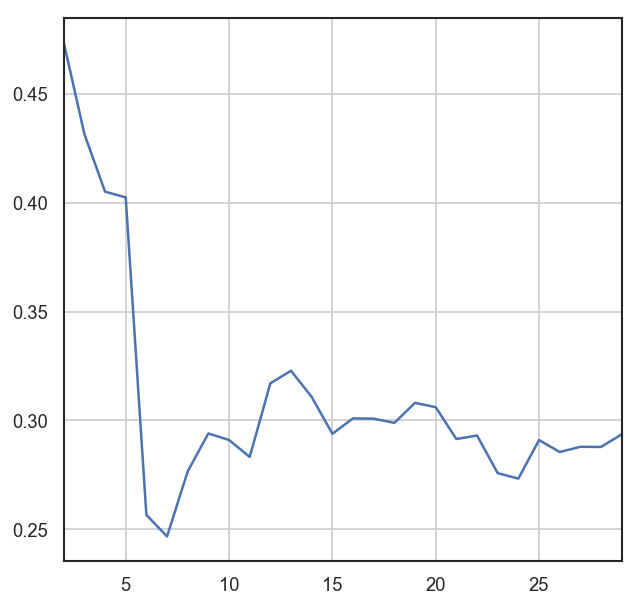

SilhouetteScore_wu_complete 2
SilhouetteScore_wu_average 2
SilhouetteScore_wu_single 4


<Figure size 432x288 with 0 Axes>

In [71]:
from sklearn.metrics import calinski_harabaz_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# There are three ways of doing this: using rclr+euclidean, bray-curtis, or unifrac

#score_types = ['CalinskiHarabaz', "SilhouetteScore"]
#suffix_types = [ "_clr", "_bc", "_wu"]

score_types = ["SilhouetteScore"]
suffix_types = [ "_wu"]
linkage_types = ["complete", "average", 'single']

cluster_params = [(i, j, k, j+i+"_"+k) for i in suffix_types for j in score_types for k in linkage_types]
print(list(zip(*cluster_params))[3][0])
clust_num_range = list(range(2,30))
clust_scores = pd.DataFrame(index=clust_num_range, columns=list(zip(*cluster_params))[3]).astype(float)
met_dict = {'CalinskiHarabaz':calinski_harabaz_score, "SilhouetteScore":silhouette_samples}

dist_dict = {}
for st, sct, lkt, colname_ in cluster_params:
    print(st, sct, lkt, colname_)
    suff_cols = [i for i in abund_md_df_derep.columns if st in i and i[:(-1*len(st))] in abund_md_df_derep.index]
    assert len(suff_cols) == len(abund_md_df_derep.index)
    normval = 1
    for i, j in zip(abund_md_df_derep.index, suff_cols):
        assert i == j[:(-1*len(st))]
    precomputed_dists = abund_md_df_derep.loc[:, suff_cols]
    dist_dict[st] = precomputed_dists.copy()
    if sct == 'SilhouetteScore':
        normval = 1
    for n_clusters_ in clust_num_range:
        cluster_mod = AgglomerativeClustering(n_clusters=n_clusters_, affinity='precomputed', linkage=lkt) 
        cluster_labels = cluster_mod.fit_predict(precomputed_dists.values)
        with_misclassified = met_dict[sct](precomputed_dists.values, cluster_labels)
        clust_scores.loc[n_clusters_, colname_] = with_misclassified[with_misclassified > 0].mean()

plt.close(); plt.clf();
fig_cscore, ax_cscore = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=120)
clust_scores.SilhouetteScore_wu_average.plot(ax=ax_cscore)
plt.grid()
fig_cscore.savefig("../otu_data/pca_plots/SilhouetteScore_WeightedUnifrac.png")
plt.show()
plt.close(); plt.clf();
for sc in clust_scores.columns:
    print(sc, clust_scores[sc].idxmax())

In [104]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

# clean clusters
for n_clusters in [5, 9, 12]:
    best_mod = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average') 
    wu_dists = dist_dict['_wu']
    cluster_labels = best_mod.fit_predict(wu_dists.values)
    sample_silhouette_values = silhouette_samples(wu_dists.values, cluster_labels)
    positive_idxs = wu_dists.index[sample_silhouette_values > -1]
    positive_silhouettes = sample_silhouette_values[sample_silhouette_values > -1]
    print(positive_silhouettes.mean())
    positive_labels = cluster_labels[sample_silhouette_values > -1]
    label_counts = np.unique(positive_labels, return_counts=1)

    good_clusts = label_counts[0][label_counts[1] > 6]
    print("all clusters", set(cluster_labels))
    print("good clusters", good_clusts)
    print("total clustered", label_counts[1][label_counts[1] > 0].sum())

    fig, ax1 = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(6,6))
    ax1.set_xlim([-.45, .8])
    ax1.set_ylim([0, len(wu_dists.values) + ((1+len(good_clusts))* 10) ])
    y_lower = 10

    clean_clusts = {}
    for i in good_clusts:
        print(i)
        ith_cluster_silhouette_values = positive_silhouettes[positive_labels == i]
        clean_clusts[i] = positive_idxs[positive_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral((float(i)*2) / (2*n_clusters))
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.35, y_lower + 0.5 * size_cluster_i, "Cluster {} : ({})".format(i, size_cluster_i), fontsize=14)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for cleaned clusters.", fontsize=14)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=14)
    ax1.set_ylabel("Cluster label", fontsize=14)
    ax1.get_yaxis().set_visible(False)
    plt.tight_layout()
    fig.savefig("../otu_data/pca_plots/sample_silhouettes_for_{}_clusters.png".format(n_clusters))
    plt.clf(); plt.close();


0.36238364788081573
all clusters {0, 1, 2, 3, 4}
good clusters [0 2 4]
total clustered 314
0
2
4
0.22713276763488996
all clusters {0, 1, 2, 3, 4, 5, 6, 7, 8}
good clusters [0 1 2 4 5 8]
total clustered 314
0
1
2
4
5
8
0.23058631214310793
all clusters {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
good clusters [ 1  2  3  5  8  9 10 11]
total clustered 314
1
2
3
5
8
9
10
11


0 Clust 1 has 97 members: SB071116TAWCSCB33CD24BR1TR2I611
1 Clust 2 has 68 members: SB062716TAWCSCB33CD12BR2TR1I87
2 Clust 3 has 34 members: SB072516TAWCSCB33CD22BR1TR1I123
3 Clust 5 has 11 members: SB061815TAWCSCB33CD0BR1TR1I3
4 Clust 8 has 49 members: SB072516TAWCSCB33CD0BR1TR2I620
5 Clust 9 has 10 members: SB061815TAWCSCB33CD18BR1TR1I22
6 Clust 10 has 17 members: SB062716TAWCSCB33CD1BR2TR1I80
7 Clust 11 has 17 members: SB071116TAWCSCB22D11BR2TR2I616
optimal minimum cophenetic distance is 0.5393668219593473


<Figure size 432x288 with 0 Axes>

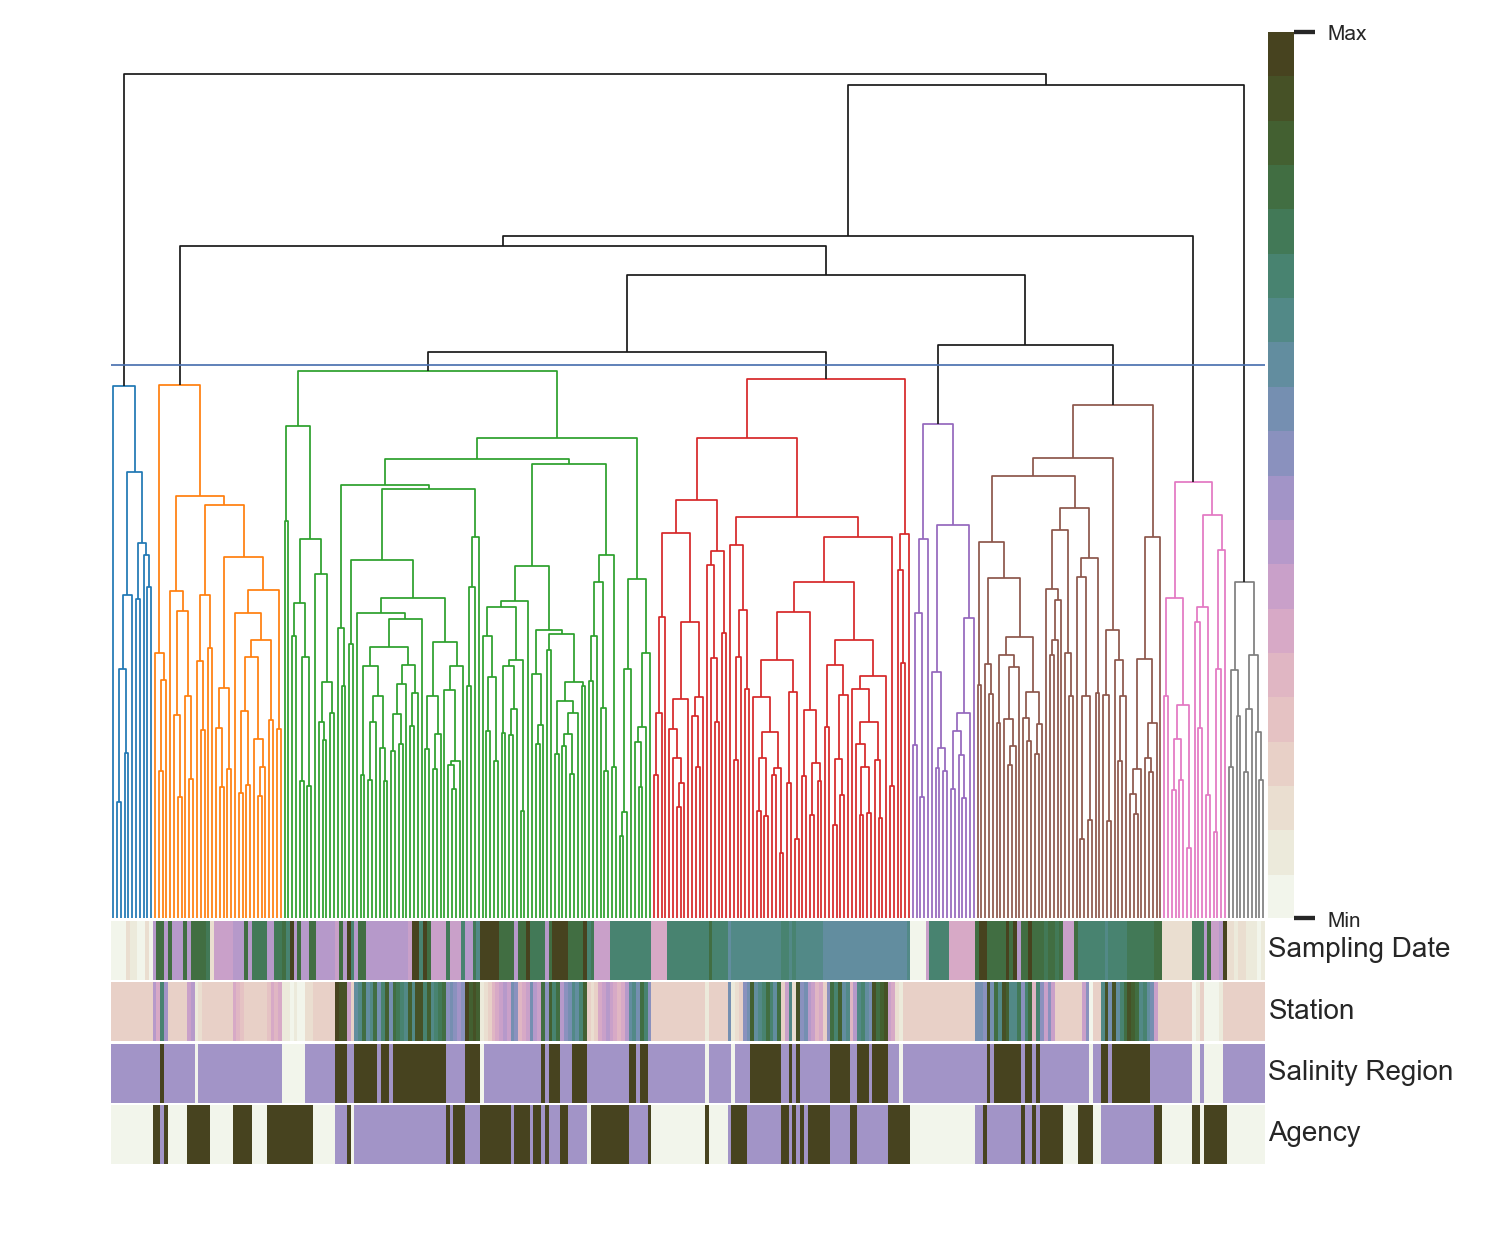

In [112]:
from scipy.cluster import hierarchy
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import scipy.spatial.distance as ssd
import matplotlib.gridspec as gridspec

clean_labs = []
for c_i, (ccn, ccv) in enumerate(clean_clusts.items()):
    print(c_i, "Clust {} has {} members: {}".format(ccn, len(ccv), ccv[0]))
    clean_labs += list(ccv)
    
ordered_index = [i for i in wu_dists.index if i in clean_labs]
ordered_columns = [i for i in wu_dists.columns if i[:-3] in clean_labs]
cleaned_df = wu_dists.loc[ordered_index, ordered_columns]
sqmat = ssd.squareform(cleaned_df.values)
toplim, botlim = sqmat.max(), sqmat[sqmat > 0.0].min()

# fix abundance and metadata tables
abund_md_df_clust = abund_md_df.loc[ordered_index, :]

opt_clusts = len(clean_clusts.values())
plt.clf()
# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 0.5
Z = hierarchy.linkage(sqmat, 'average', optimal_ordering=True)
fig_ = plt.figure(figsize=(7, 6), dpi=250)
gs = gridspec.GridSpec(5, 4, figure=fig_, wspace=0.01, hspace=0.01, 
                       height_ratios=[75,5,5,5,5], width_ratios=[18,.4,1.3,1.3])
ax1 = plt.subplot(gs[0,0])


for c_height in np.arange(botlim*0.1, toplim*1.1, botlim*.01):
    cuttree = hierarchy.cut_tree(Z, height=[c_height])
    if len(set(list(cuttree[:, 0]))) <= opt_clusts:
        break

#c_height = 0.55

print("optimal minimum cophenetic distance is {}".format(c_height))
hierarchy.set_link_color_palette(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                  'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
                                  'tab:olive', 'tab:cyan'])

res = hierarchy.dendrogram(Z, color_threshold=c_height*1.01, get_leaves=True, 
                           ax=ax1, labels=cleaned_df.index, no_labels=True, 
                           above_threshold_color='k')
ax1.axhline(y=c_height*1.01)
ax1.axis('off')
matplotlib.rcParams['lines.linewidth'] = 1.5

# get axis order
new_idx = cleaned_df.index[res['leaves']]
# metadata columns to plot
sel_md_cols = ['Month_Year', 'StationName', #'Pycnocline', 
               'Salinity_Group', 'sequencing ID', 'CollectionAgency']
# resort metadata
clustered_metadata = abund_md_df_derep.loc[new_idx, sel_md_cols].copy()
# encode colors and reverse
color_codings = [{1:'06 15', 2:'07 15', 3:'08 15', 7:'06 16', 8:'07 16', 9:'08 16', 
                  13:'04 17', 14:'05 17', 15:'06 17', 16:'07 17', 17:'08 17', 20:'09 17'},
                 {4:'CB33C', 1:'CB22', 5:'CB41C', 7:'CB43C', 8:'CB44', 9:'CB51', 10:'CB52', 
                  11:'CB53', 12:'CB54', 17:'CB71', 14:'CB62', 15:'CB63', 18:'CB72', 16:'CB64', 
                  20:'CB74', 2:'CB31', 3:'CB32', 6:'CB42C', 13:'CB61', 19:'CB73'},
                 #{1:'Above', 20:'Below', 10:np.nan}, 
                 {10:'Mesohaline', 1:'Oligohaline', 20:'Polyhaline'},
                 {1:'sprehei1_123382', 4:'Miseq_data_SarahPreheim_Sept2016', 7:'esakows1_132789', 
                  10:'Keith_Maeve1_138650', 13:'sprehei1_149186', 17:'esakows1_152133_plate_1', 
                  20:'esakows1_152133_plate_2'}, {1:"Preheim", 10:"ODU", 20:"DNR"}]

rev_col_codes = []
for x in color_codings:
    rev_col_codes.append({j:i for i, j in x.items()})

# map encodings
for sdc, cmapping in zip(sel_md_cols, rev_col_codes):
    clustered_metadata[sdc] = clustered_metadata[sdc].map(cmapping)

# select palette with max # of categories
#all_col_pal = sns.color_palette("cubehelix_r", clustered_metadata.max().max())
all_col_pal = sns.cubehelix_palette(n_colors=clustered_metadata.max().max(), start=.3, rot=1.5, gamma=1.0,
                                    hue=0.7, light=0.95, dark=0.25, reverse=0)
cmap_ = LinearSegmentedColormap.from_list('Custom', tuple(all_col_pal), len(tuple(all_col_pal)))

mdata_nrow = clustered_metadata.shape[0]
# plot first row and bar
ax2 = plt.subplot(gs[1,0])
ax2l = plt.subplot(gs[1,1:])
ax2_vals = clustered_metadata['Month_Year'].values.reshape(mdata_nrow,1).T
sns.heatmap(ax2_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax2)
ax2l.text(0.,0.4, "Sampling Date", fontdict={'fontsize':8})
ax2.axis('off'); ax2l.axis('off');

ax4 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[0,1])
ax4_vals = clustered_metadata['StationName'].values.reshape(mdata_nrow,1).T
stat_ax = sns.heatmap(ax4_vals, linewidths=0.0, cmap=cmap_, cbar=True, cbar_ax=ax3, xticklabels=False, yticklabels=False, ax=ax4)
cb = stat_ax.collections[0].colorbar
cb.ax.tick_params(labelsize=6);
cb.set_ticks([1, 20]); cb.set_ticklabels(['Min', 'Max']); 
ax4l = plt.subplot(gs[2,1:])
ax4l.text(0.,0.4, "Station", fontdict={'fontsize':8})
ax4.axis('off'); ax4l.axis('off');

ax6 = plt.subplot(gs[3,0])
ax6l = plt.subplot(gs[3,1:])
ax6_vals = clustered_metadata['Salinity_Group'].values.reshape(mdata_nrow,1).T
sns.heatmap(ax6_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax6)
ax6l.text(0.,0.4, "Salinity Region", fontdict={'fontsize':8})
ax6.axis('off'); ax6l.axis('off');

#ax7 = plt.subplot(gs[4,0])
#ax7l = plt.subplot(gs[4,1:])
#ax7_vals = clustered_metadata["Pycnocline"].values.reshape(mdata_nrow,1).T
#sns.heatmap(ax7_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax7)
#ax7l.text(0.,0.4, "Pycnocline", fontdict={'fontsize':6})
#ax7.axis('off'); ax7l.axis('off');

ax8 = plt.subplot(gs[4,0])
ax8l = plt.subplot(gs[4,1:])
ax8_vals = clustered_metadata["CollectionAgency"].values.reshape(mdata_nrow,1).T
sns.heatmap(ax8_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax8)
ax8l.text(0.,0.4, "Agency", fontdict={'fontsize':8})
ax8.axis('off'); ax8l.axis('off');

fig_.savefig('../otu_data/pca_plots/pca_of_wu_avlinkage_clusters_clean.png', dpi=250)


#### Lets make PCA plots colored by metadata columns

Decomposing Weighted Unifrac dist table (303, 303)


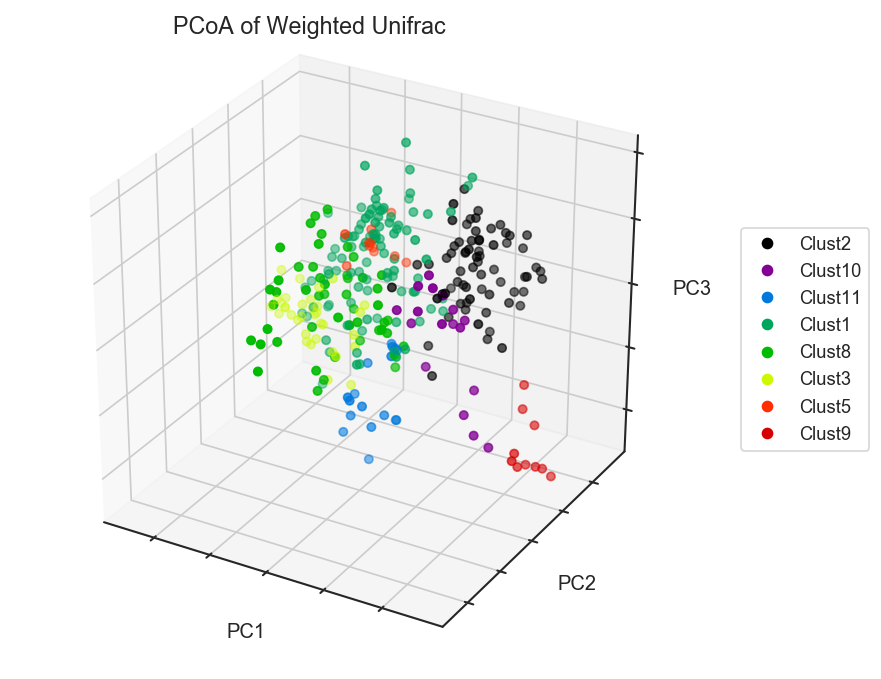

In [111]:
from deicode.optspace import OptSpace

rename_cols = {i - 1: 'PC' + str(i) for i in range(1, 3)}

print("Decomposing {} dist table {}".format('Weighted Unifrac', cleaned_df.shape))
opt_i = OptSpace(rank=2).fit(cleaned_df.values)
sl_i = pd.DataFrame(opt_i.sample_weights, index=cleaned_df.index)
sample_loadings = sl_i.rename(columns=rename_cols)

rev_cc_mapping = {k:"Clust"+str(i) for i,j in clean_clusts.items() for k in j}

clustcolors = [cm.nipy_spectral((float(i)*2) / 24) for i in range(12)]
keithcm = LinearSegmentedColormap.from_list('keithspec', clustcolors, N=len(clustcolors))

mdf = pd.DataFrame(index=cleaned_df.index, columns=['ClustAssgns'])
mdf['ClustAssgns'] = cleaned_df.reset_index()['Samples'].map(rev_cc_mapping).values

from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
plt.clf(); plt.close();
dm = DistanceMatrix(cleaned_df.values, cleaned_df.index)
pcoa_results = pcoa(dm)
fig = pcoa_results.plot(df=mdf, column='ClustAssgns',
                        title='', cmap=keithcm, s=25)

fig.set_size_inches(w=8, h=6, forward=True)
fig.suptitle("PCoA of Weighted Unifrac", x=0.34, y=0.95, fontsize=14)
ax = plt.gca()
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
fig.set_dpi(120)
fig.savefig("../otu_data/pca_plots/3d_pca_wu_coloredbyclust.png")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')

mdata_clean = meta_df_x.loc[]
print(select_metadata)
select_mdata = select_metadata + ['Latitude', 'Longitude', 'RawCount_b', 'TrimCount_b', 'Cluster']

metas_ls = {'encoded':{}, 'raw':{}, 'encoding':{}, 'rev_coding':{}}
for sm in select_mdata:
    nct = meta_df_x[sm].isnull().sum()
    metas_ls['raw'][sm] = meta_df_x[sm].tolist()
    metas_ls['encoding'][sm] = {raw:code for code, raw in enumerate(sorted(set(metas_ls['raw'][sm])))}
    metas_ls['encoded'][sm] = [metas_ls['encoding'][sm][r] for r in metas_ls['raw'][sm]]
    metas_ls['rev_coding'][sm] = {code:raw for raw, code in metas_ls['encoding'][sm].items()}
    uct = len(metas_ls['encoding'][sm])

title_i = 'WeightedUnifracDists'

plt.clf()
fig, ax_i = plt.subplots(nrows=1, ncols=1, figsize=(12,12), dpi=250)
ax_i.set_title("{}, colored by sequencing run".format(title_i))
ticks_, labels_ = zip(*metas_ls['rev_coding']['sequencing_ID'].items())
cmap_i = plt.cm.get_cmap('Spectral', len(labels_))
im = ax_i.scatter(sample_loadings.iloc[:, 0], 
                  sample_loadings.iloc[:, 1], 
                  c=metas_ls['encoded']['sequencing_ID'], 
                  edgecolor='k', alpha=0.8, cmap=cmap_i)
cbar = fig.colorbar(im, ticks=ticks_)
cbar.ax.set_yticklabels(labels_)     
ax_i.set_xlabel(sample_loadings.columns[0])
ax_i.set_ylabel(sample_loadings.columns[1])
ax_i.set_facecolor('0.6')
ax_i.set_axisbelow(True)
ax_i.minorticks_on()
ax_i.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
ax_i.grid(which='minor', linestyle='-', linewidth='0.25', color='black')
#    texts = []
#    from adjustText import adjust_text
#    for ctrl_ in control_libs:
#        x = sample_loadings[title_i].loc[ctrl_, 'PC1']
#        y = sample_loadings[title_i].loc[ctrl_, 'PC2']
#        s = meta_data_df2.loc[ctrl_, 'Short sample name'] + "_" + sid_map[meta_data_df2.loc[ctrl_, 'sequencing ID']]
#        texts.append(plt.text(x, y, s))       
#    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
fig.subplots_adjust(right=0.8)
figname = "PCA_{}_abthresh_seq_run_colors.png".format(title_i)
figpath = os.path.join("../otu_data/pca_plots", figname)
print("Saving {}".format(figname))
plt.savefig(figpath)
plt.clf()
plt.close()
    

Cluster Label
Clust1     291097.0
Clust10     51017.0
Clust11     51017.0
Clust2     204068.0
Clust3     102034.0
Clust5      33011.0
Clust8     147049.0
Clust9      30010.0
dtype: float64
(8, 50)
The collapsed taxa table is (8, 20)
20 colors grabbed


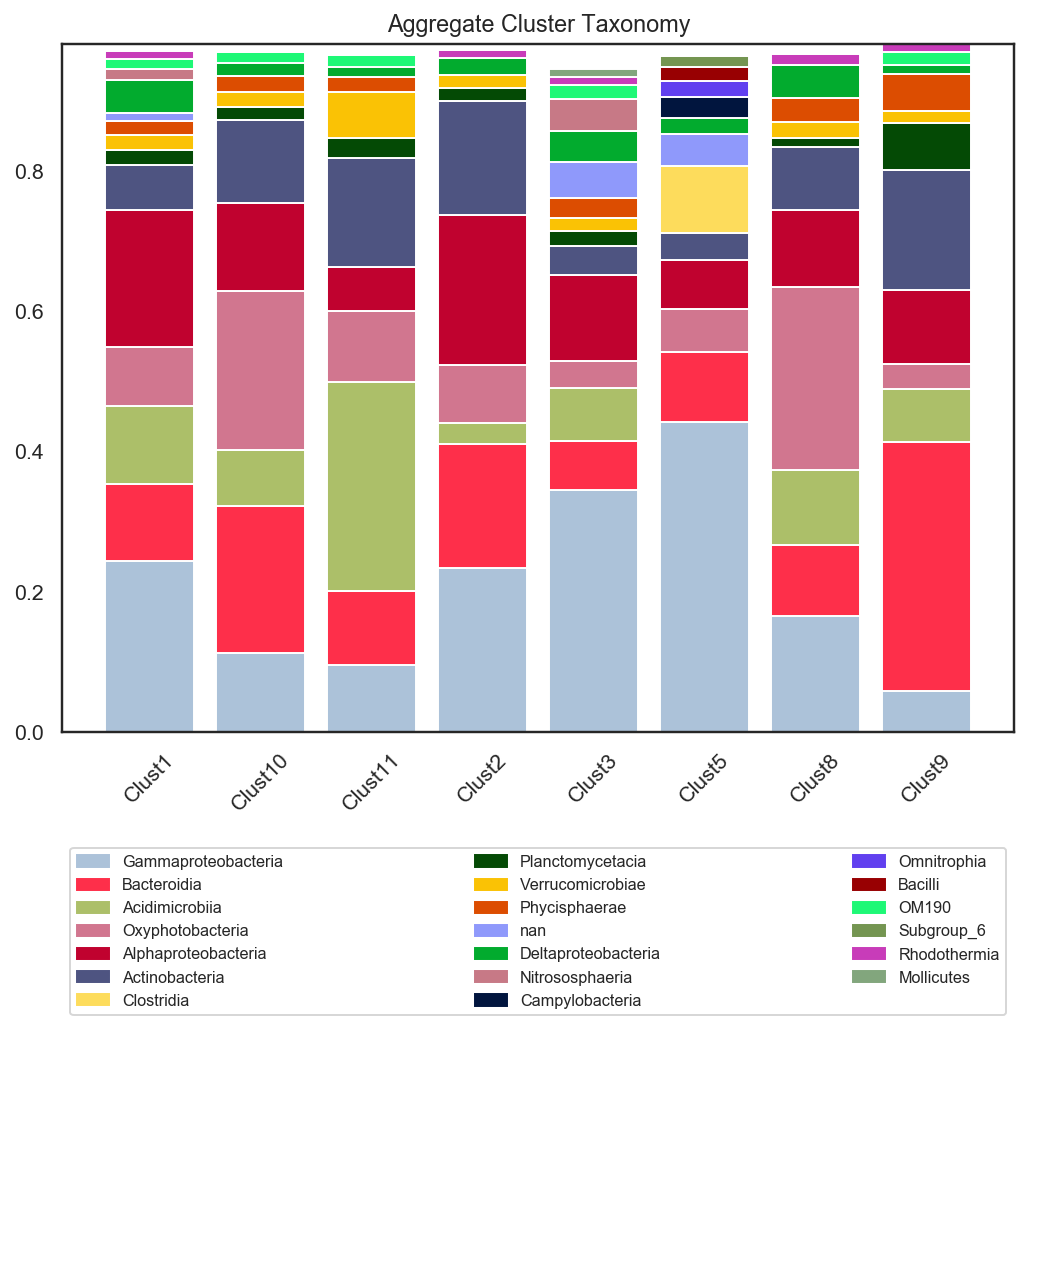

Saving TaxaClusters_Class.png
(8, 128)
The collapsed taxa table is (8, 48)
48 colors grabbed


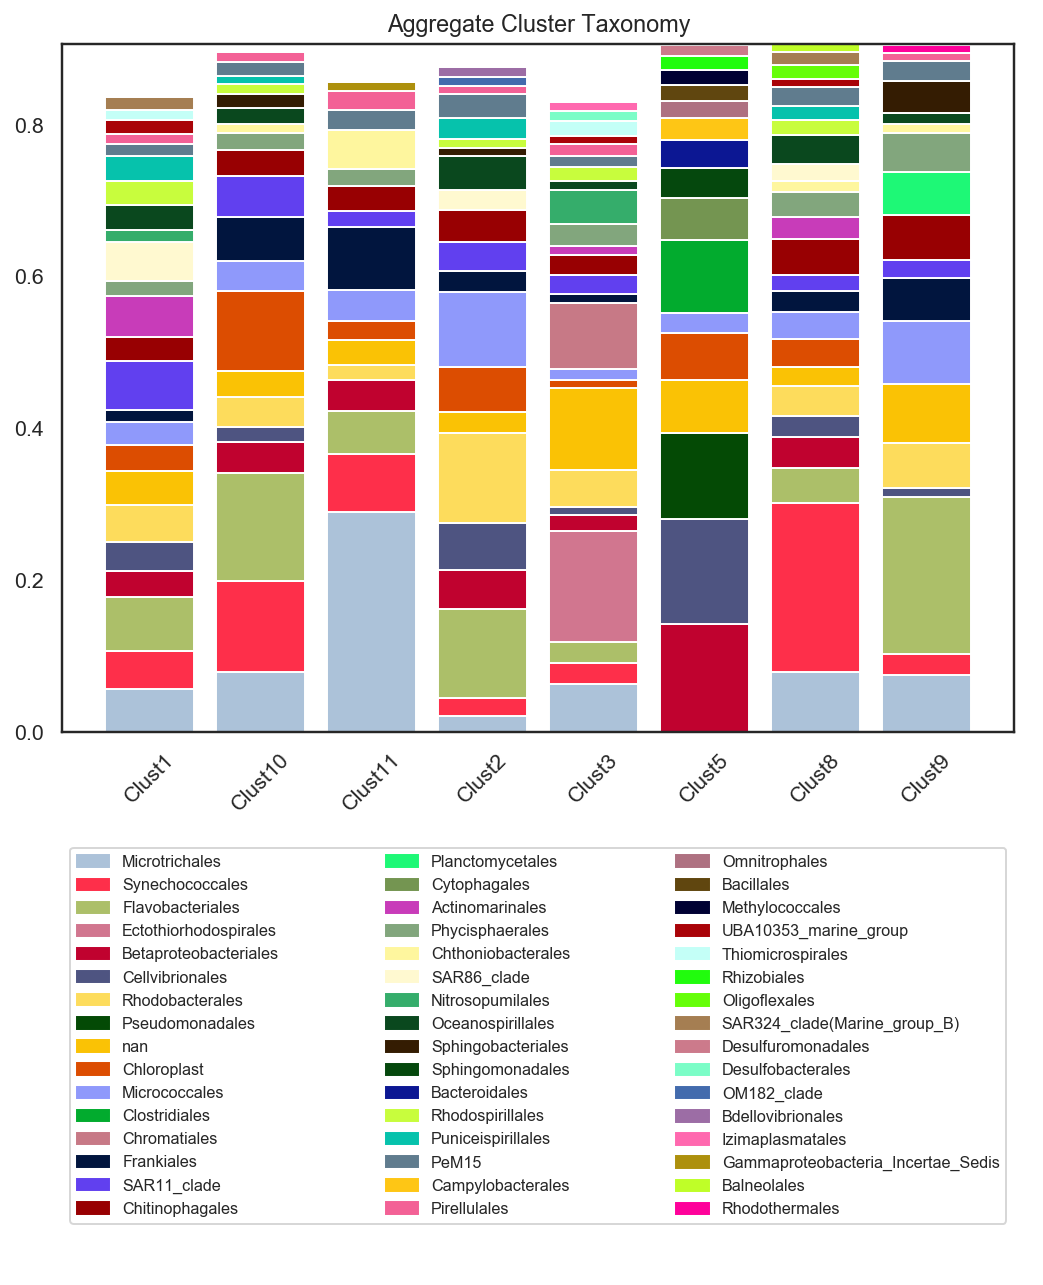

Saving TaxaClusters_Order.png


In [123]:
import matplotlib.patches as mpatches
# calculate cluster sums 

temp_amdf = abund_md_df_clust.reset_index()
temp_amdf['Cluster Label'] = temp_amdf['Samples'].map(rev_cc_mapping)
ab_md_df_dr_cl = temp_amdf.set_index('Samples')
cols_to_group = list(rare_abund.columns)+['Cluster Label']
ab_df_dr_cl = ab_md_df_dr_cl.loc[:, cols_to_group]
cluster_sums = ab_df_dr_cl.groupby('Cluster Label').agg(np.sum).sort_index()
print(cluster_sums.sum(1))

def taxa_breakdown(abunds_, taxas_, level_, weighted=True, flatten_val=0.0):
    # 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'
    # remove non-existant features
    flip_abunds = abunds_.loc[:, abunds_.sum(0) > 0].T
    # create presence or absence table if need be
    if not weighted:
        flip_abunds = (flip_abunds > 0).astype(int)
    # add level column
    otu_fetch = lambda x: taxas_.loc[x, level_]
    flip_abunds['otu_name'] = flip_abunds.index
    flip_abunds['taxa_name'] = flip_abunds['otu_name'].apply(otu_fetch)
    flip_abunds.drop('otu_name', axis=1, inplace=True)
    ttable_raw = flip_abunds.groupby('taxa_name').agg(np.sum)
    ttable = ttable_raw.div(ttable_raw.sum(0))
    if flatten_val:
        flat_ttv = ttable.values
        flat_ttv[flat_ttv < flatten_val] = 0.0
        ttable = pd.DataFrame(flat_ttv, index=ttable.index, columns=ttable.columns)
    return ttable.T


abunds_1 = cluster_sums.copy()
taxas_1 = taxa_df.copy().astype(str)
for level_1 in ['Class', 'Order']:
    ttable_1 = taxa_breakdown(abunds_1, taxas_1, level_1, weighted=True, flatten_val=0.01)
    print(ttable_1.shape)
    ttable_1 = ttable_1.loc[:, ttable_1.columns[ttable_1.sum() > 0]]
    print("The collapsed taxa table is {}".format(ttable_1.shape))

    col_order = ttable_1.max().sort_values(ascending=False).index
    ttable_1 = ttable_1.loc[:, col_order]

    fignamet = "TaxaClusters_{}.png".format(level_1)
    figpatht = os.path.join("../otu_data/pca_plots", fignamet)

    plt.clf(); plt.close();
    fig_width = 8
    fig_t = plt.figure(figsize=(fig_width,10), dpi=140)
    gs = gridspec.GridSpec(2, 1, figure=fig_t, height_ratios=[7,4], hspace=.2,
                           bottom=0.075, top=0.925, right=0.925, left=0.075)
    ax_arr = [plt.subplot(gs[0,0])]

    possible_colors = [j for i, j in sns.xkcd_rgb.items() if not 'white' in i]
    np.random.seed(2)
    colors_needed = np.random.choice(possible_colors, size=ttable_1.columns.shape)
    print("{} colors grabbed".format(len(colors_needed)))

    # loop over each table to plot
    axis_titles = ['Aggregate Cluster Taxonomy']
    for ax_ix, table_x in enumerate([ttable_1]):
        # pick an axis
        ax_i = ax_arr[ax_ix]
        ax_i.set_title(axis_titles[ax_ix])
        # set the width of each bar to the number of samples
        adjusted_width = (fig_width / table_x.shape[0])*(.8)
        # set the left bottom anchor of each bar
        bar_locs = np.arange(table_x.shape[0])*(fig_width / table_x.shape[0])
        # set the bar labels 
        bar_names = table_x.index
        # loop over each taxon name
        for bar_n, bar_col in enumerate(table_x.columns):
            # subset those fractions across samples
            bar_x = table_x.loc[:, bar_col]
            # set the y-axis location for each bar
            if bar_n == 0:
                running_base = bar_x*0.0
            # Create an individual bar
            ax_i.bar(bar_locs, bar_x.values, bottom=running_base.values, 
                     color=colors_needed[bar_n], edgecolor='white', 
                     width=adjusted_width, tick_label=bar_names)
            for tick in ax_i.get_xticklabels():
                tick.set_rotation(45)
            # increment the bottoms
            running_base = running_base + bar_x

    ax2 = plt.subplot(gs[1,0])
    patches = [mpatches.Patch(color=color, label=label) for label, color in zip(list(ttable_1.columns), colors_needed)]
    ax2.legend(patches, list(ttable_1.columns), loc='best', bbox_to_anchor=(0., 0., 1., 1.),
               mode='expand', fontsize='x-small', ncol=3)

    ax2.axis('off')
    # Show graphic
    plt.show()
    print("Saving {}".format(fignamet))
    fig_t.savefig(figpatht, dpi=140)
    plt.show();
    plt.clf(); plt.close();
    
    

#### This is where we write out the rarefied matrix and calculate (if not done) and write out alpha diversity stats.

In [132]:
abund_md_df_clust['Cluster Label'] = ab_md_df_dr_cl.loc[abund_md_df_clust.index, 'Cluster Label'].copy()

cols_to_check = ['StationName', 'Month_Year', 'DepthName', 'Month', 
                 'Year', 'Salinity_Group', 'sequencing_ID']
for clust in abund_md_df_clust['Cluster Label'].unique():
    subdf = abund_md_df_clust[abund_md_df_clust['Cluster Label'] == clust]
    subdf_alpha = subdf.loc[:, ['faith_pd', 'observed_otus', 'enspie']]
    pct_fxn = lambda x: np.percentile(x, [0, 2.5, 50, 97.5, 100])
    alpha_stats = subdf_alpha.apply(pct_fxn)
    num_samps = subdf.shape[0]
    print(clust, num_samps)
    print(alpha_stats)
    for col_s in cols_to_check:
        n_x, x_x = np.unique(subdf[col_s].values, return_counts=1)
        print(col_s, len(n_x))
        for n, x in zip(n_x, x_x):
            print("\t{}: {:.2%}".format(n, x/num_samps))        
        input()
    


        
        



Clust2 68
    faith_pd  observed_otus     enspie
0  21.060734        146.000   9.862241
1  22.476885        154.075  20.606874
2  34.347257        262.000  47.074990
3  45.732264        350.950  88.333812
4  53.021104        406.000  94.312633
StationName 15
	CB31: 4.41%
	CB32: 4.41%
	CB33C: 35.29%
	CB42C: 2.94%
	CB43C: 2.94%
	CB44: 4.41%
	CB51: 2.94%
	CB53: 4.41%
	CB54: 5.88%
	CB61: 5.88%
	CB62: 5.88%
	CB63: 5.88%
	CB71: 5.88%
	CB72: 4.41%
	CB73: 4.41%
x
Month_Year 5
	04 17: 33.82%
	05 17: 32.35%
	06 16: 5.88%
	06 17: 26.47%
	08 17: 1.47%
x
DepthName 21
	01: 25.00%
	02: 2.94%
	06: 1.47%
	07: 1.47%
	08: 4.41%
	09: 2.94%
	10: 10.29%
	11: 4.41%
	12: 5.88%
	13: 5.88%
	14: 2.94%
	15: 1.47%
	19: 1.47%
	20: 4.41%
	21: 2.94%
	24: 4.41%
	25: 4.41%
	26: 2.94%
	27: 2.94%
	31: 4.41%
	33: 2.94%
x
Month 4
	4: 33.82%
	5: 32.35%
	6: 32.35%
	8: 1.47%
x
Year 2
	16: 5.88%
	17: 94.12%
x
Salinity_Group 3
	Mesohaline: 63.24%
	Oligohaline: 4.41%
	Polyhaline: 32.35%
x
sequencing_ID 6
	KM: 13.24%
	Miseq_sp: 4

#### Read in water quality data

In [ ]:
melted_file = "../otu_data/WaterQualityData/melted_wq_07to17.tsv"
if not os.path.exists(melted_file):
    db_file = "../otu_data/WaterQualityData/WaterQualityData_07to17.tsv"
    df_raw = pd.read_csv(db_file, sep="\t", parse_dates=[['SampleDate', 'SampleTime']], low_memory=False)
    df_nn = df_raw[df_raw.MeasureValue.notnull()]
    df_nn['SampleDate_SampleTime'] = df_nn.SampleDate_SampleTime.apply(pd.to_datetime)
    summer_idxs = set()
    for yr_i, yr in enumerate(range(2012,2018)):
        left_side = pd.to_datetime(str(yr)+'-03-15')
        right_side = pd.to_datetime(str(yr)+'-10-15')
        date_range_ = (df_nn.SampleDate_SampleTime >= left_side) & (df_nn.SampleDate_SampleTime < right_side)
        summer_idxs.update(df_nn[date_range_].index)
        print("Window {} is {} to {}, grabbed {} total".format(yr_i, left_side, right_side, len(summer_idxs)))

    df_nv = df_nn.loc[summer_idxs, :]
    df_nv.loc[df_nv.Problem == 'NV', 'Problem'] = np.nan
    df_nv.loc[df_nv.Problem == 'QQ', 'Problem'] = np.nan
    df_nv.loc[df_nv.Problem == 'WW', 'Problem'] = np.nan
    df_np = df_nv[df_nv.Problem.isnull()]

    needed_cols = ['TotalDepth', 'UpperPycnocline', 'LowerPycnocline']
    idx_cols = ["SampleDate_SampleTime", "Station", "Depth"]
    new_df = pd.pivot_table(data = df_np, index = idx_cols, columns = 'Parameter', 
                            values = 'MeasureValue', aggfunc=np.mean).sort_index()

    addl_cols = df_np.loc[:, idx_cols+needed_cols].groupby(idx_cols).agg(np.mean).sort_index()
    wq_melted = new_df.join(addl_cols)
    wq_melted.to_csv(melted_file, sep="\t")
else:
    print("Reading melted water quality data from file")
    wq_melted_df = pd.read_csv(melted_file, sep="\t")
    print("Df size {}".format(wq_melted_df.shape))
    print("First index: ", wq_melted_df.iloc[0, :3].values, "\nLast Index: ", wq_melted_df.iloc[-1, :3].values)
    print(wq_melted_df.isnull().sum().sort_values())

# Get actual pycnocline locations

In [ ]:
def date1(x):
    a = [float(i) for i in x.split()[0].split("-")]
    return a[0] + a[1]/12 + a[2]/(365.3333)

def date2(a):
    return float(a[:2])/(12) + float(a[2:4])/(365.3333) + (float(a[4:])+2000)

super_matched = super_df.copy()[super_df.DepthName != 'LAB']
wq_melted_df['date_float'] = pd.to_datetime(wq_melted_df['SampleDate_SampleTime']).astype(np.int64) // 10**9
super_matched['date_float'] = pd.to_datetime(super_matched['DateMMDDYY'], format="%m%d%y").astype(np.int64) // 10**9
super_matched['SpaceTime'] = super_matched.loc[:, ['DateMMDDYY', 'date_float', 'StationName']].apply(tuple, axis=1)

isint = lambda x: True if x%1.0 == 0 else False
water_nzd = wq_melted_df[(wq_melted_df.Depth != 0) & wq_melted_df.Depth.apply(isint)]

idx_names = ['DateMMDDYY', 'date_float', 'StationName']
wqm_idx = pd.MultiIndex.from_tuples([tuple(i) for i in super_matched.SpaceTime.unique()], names=idx_names)
wqm_df = pd.DataFrame(index=wqm_idx, columns=['DensityMatchDate', 'DensityTimeDelta',
                                              'PycDepth', 'BVF', 'FoldChange']).sort_index()

density_profiles = []

for sd_x in wqm_df.index:
    mdy_t, ux_t, stat_ = sd_x
    stat_mod = stat_[:3] +"." + stat_[3:5]
    stat_select = water_nzd[water_nzd.Station == stat_mod]
    #print(stat_mod, mdy_t, stat_select.shape)
    donebool = False
    timediff = abs(stat_select.date_float - ux_t) / (24*60**2)
    while not donebool:
        matched_time, time_delt = timediff.idxmin(), timediff.min()
        selected_time = stat_select.loc[matched_time, 'SampleDate_SampleTime']
        time_select = stat_select[stat_select.SampleDate_SampleTime == selected_time]
        #print(selected_time, mdy_t, time_select.shape)
        select_densities = time_select.sort_values(['Depth']).loc[:, ['Depth', 'SIGMA_T']]
        depth_gradient = np.gradient(select_densities.SIGMA_T.values, select_densities.Depth.values)
        select_densities['BVF'] = pd.Series(depth_gradient, index=select_densities.index)
        select_densities = select_densities[select_densities.Depth > 2.0]
        if select_densities.BVF.isnull().sum() > 2:
            print("bad date")
            donebool = True
            timediff = timediff[timediff > time_delt]
        else:
            donebool = True
            wqm_df.loc[sd_x, 'PycDepth'] = select_densities.loc[select_densities['BVF'].idxmax(), 'Depth']
            wqm_df.loc[sd_x, 'BVF'] = select_densities.loc[select_densities['BVF'].idxmax(), 'BVF']
            wqm_df.loc[sd_x, 'FoldChange'] = wqm_df.loc[sd_x, 'BVF']/np.median(select_densities['BVF'])
            wqm_df.loc[sd_x, 'DensityMatchDate'] = selected_time
            wqm_df.loc[sd_x, 'DensityTimeDelta'] = time_delt
            density_profiles.append(select_densities.copy())


"""
# maybe make date distance threshold harsher
# get precipitation and windspeed data to confirm
# should make options for upper/lower water column w/o stratification
"""

for new_var in ['Pycnocline', 'dSigmaT_dDepth', 'PycDepth']:
    super_matched[new_var] = pd.Series([np.nan]*super_matched.shape[0], index=super_matched.index)

wqm_df = wqm_df[wqm_df.DensityTimeDelta < 5]
wqm_df = wqm_df[wqm_df.FoldChange.notnull()]
wqm_df = wqm_df[wqm_df.FoldChange > 3]


for dat_MDY, date_flt, statn in wqm_df.index:
    #print(tuple([dat_MDY, date_flt, statn]))
    this_depth = wqm_df.PycDepth[tuple([dat_MDY, date_flt, statn])]
    this_bvf = wqm_df.BVF[tuple([dat_MDY, date_flt, statn])]
    dat_bool = super_matched['DateMMDDYY'] == dat_MDY
    dflt_bool = super_matched['date_float'] == date_flt 
    stat_bool = super_matched['StationName'] == statn
    above_bool = super_matched['DepthName'].astype(int) <= this_depth
    below_bool = super_matched['DepthName'].astype(int) > this_depth
    super_matched.loc[dat_bool & dflt_bool & stat_bool & above_bool, 'Pycnocline'] = 'Above'
    super_matched.loc[dat_bool & dflt_bool & stat_bool & below_bool, 'Pycnocline'] = 'Below'
    super_matched.loc[dat_bool & dflt_bool & stat_bool, 'PycDepth'] = this_depth
    super_matched.loc[dat_bool & dflt_bool & stat_bool, 'dSigmaT_dDepth'] = this_bvf



#### Look at results of density gradient calculations 

In [ ]:
wqm_df_full = wqm_df.reset_index()
wqm_df_full['FoldChange'] = wqm_df_full['FoldChange'].astype(float)
wqm_df_full['StatEncoded'] = wqm_df_full.loc[:, 'StationName'].map(metas_ls['encoding']['StationName'])
wqm_df_full['DatEncoded'] = wqm_df_full.loc[:, 'DateMMDDYY'].map(metas_ls['encoding']['DateMMDDYY'])

wqm_pivot = pd.pivot_table(wqm_df_full, columns=['StatEncoded'], values=['FoldChange'], 
                           index=['DatEncoded'], fill_value=-1.)

mask = np.zeros_like(wqm_pivot.values)
mask[wqm_pivot.values == -1.] = True
fc_fig, fc_ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=120)
ax_fc = sns.heatmap(wqm_pivot.values*-1, mask=mask, vmin=-30, vmax=4, ax=fc_ax)
ax_fc.set_title('Fold Change in Brunt–Väisälä Frequency at Pycnocline', fontsize=12)
ax_fc.set(xlabel='Dates', ylabel='Stations')
plt.show()

#### SPARCC Out

In [ ]:
sparcc_dir = "../otu_data/sparcc_data"
sparcc_file = os.path.join(sparcc_dir, "filtered_otu_table.txt")
if os.path.exists(sparcc_file):
    just_abunds = pd.read_csv(sparcc_file, sep="\t", index_col=0).T
else:
    just_abunds = abund_md_df_derep.loc[:, abund_df_og_s1.columns].T
    just_abunds.to_csv(sparcc_file, sep="\t", index_label='OTU_id')

print(just_abunds.shape)

#### SPARCC In

In [ ]:
"""
from statsmodels.stats.multitest import multipletests

corrs_file = "/Volumes/KeithSSD/CB_V4/otu_data/sparcc_data/sparcc_corr.out"
df = pd.read_csv(corrs_file, sep="\t", index_col=0)
pval_file = "/Volumes/KeithSSD/CB_V4/otu_data/sparcc_data/test_pvals.two_sided.txt"
p_df = pd.read_csv(pval_file, sep="\t", index_col=0)

assert df.index.equals(p_df.index)
assert df.columns.equals(p_df.columns)

def melt_upper_triangle(df_, val_str):
    dfnan = df_.where(np.triu(np.ones(df_.shape)).astype(np.bool))
    melted_df = dfnan.stack().reset_index()
    melted_df.columns = ['OTU_1','OTU_2', val_str]
    melted_df2 = melted_df[melted_df['OTU_1'] != melted_df['OTU_2']]
    return melted_df2.set_index(['OTU_1', 'OTU_2'])

mpdf = melt_upper_triangle(p_df, 'p-value')
mdf = melt_upper_triangle(df, 'correlation')

fulldf = mdf.join(mpdf)

# pull total abundances
# pull taxonomy (order?)

reject, pvals_corrected = multipletests(fulldf['p-value'].values, alpha=0.05, method='fdr_bh')[:2]

thresholded = fulldf.loc[fulldf.index[reject], ['correlation']].reset_index()
"""
corr_cutoff = abs(thresholded.correlation) > 0.3
thresholded_cutoff = thresholded[corr_cutoff]
print(thresholded_cutoff.shape)


In [ ]:


# conver to relative abundance 
ja_ra = just_abunds.div(just_abunds.sum(1), axis=0)

thresh_plus_scores = thresholded_cutoff.copy()
# pool by cluster i.e. sum rows and divide by number of them
clust_ra = pd.DataFrame(index=clean_clusts.keys(), columns=ja_ra.columns)
for clust, membs in clean_clusts.items():
    n_mems = len(membs)
    clust_row = ja_ra.loc[membs, :].sum() / n_mems
    clust_ra.loc[clust, :] = clust_row
    pool_clust = lambda x: clust_ra.loc[clust, [x[0], x[1]]].sum()
    colname = "clust_{}_score".format(clust)
    thresh_plus_scores[colname] = thresh_plus_scores.loc[:, ['OTU_1', 'OTU_2']].apply(pool_clust, axis=1)
    print(colname, 'done')
    
order_otu_one = thresh_plus_scores.OTU_1.apply(lambda x: taxa_df.loc[x, 'Phylum'])
order_otu_two = thresh_plus_scores.OTU_2.apply(lambda x: taxa_df.loc[x, 'Phylum'])
order_otu_two.name = "OTU_2_Taxonomy"
order_otu_one.name = "OTU_1_Taxonomy"
thresh_cut_taxa = thresh_plus_scores.join(order_otu_one).join(order_otu_two)
thresh_cut_taxa.to_csv("/Volumes/KeithSSD/CB_V4/otu_data/sparcc_data/corr_net.txt", sep="\t", index=False)
thresh_cut_taxa.head()
"""
ca_colnorm = clust_ra.div(clust_ra.sum(0), axis=1)

print("Top {} OTU Intersections")
for clust1 in clean_clusts.keys():
    c1_row = ca_colnorm.loc[clust1, :].sort_values(ascending=False)
    c1_anchors = set(c1_row[c1_row == 1].index)
    in_first_col = thresholded_cutoff.OTU_1.isin(c1_anchors)
    in_second_col = thresholded_cutoff.OTU_2.isin(c1_anchors)
    retained_rows = thresholded_cutoff[in_first_col | in_second_col]
    retained_pct = retained_rows.shape[0] / thresh_cut_taxa.shape[0]
    print("{} has {} anchors which retain {}/{:.2%} of edges in graph".format(clust1, len(c1_anchors),
                                                                              retained_rows.shape[0], retained_pct))
"""



#### This reformats the guppy distance matrix into something usable and symmetric

In [ ]:
dist_file = "../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.dist.tab"

triang_arr = [[0]]
rec_n = 1
with open(dist_file, "r") as dih:
    for ix, l in enumerate(dih):
        rec_n += 1
        triang_arr.append(l.replace("S", "").replace("P", "").split()+[0.])
        

full_arr = np.array([x+[0.0]*(rec_n-len(x)) for x in triang_arr], dtype=float)
dist_df = pd.DataFrame(full_arr + full_arr.T)
dist_df.index = list(dist_df.index)
dist_df.columns = list(dist_df.columns)
print(dist_df.shape)
print(dist_df.index[:5])
print(dist_df.columns[:5])

### Here we will read in pplacer file and collapse the abundance table according to edge placements

In [ ]:
import matplotlib.pyplot as plt

# read in the pplacer placements data
pplacements = '../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.csv'
pp_df = pd.read_csv(pplacements, index_col=1)

# calculate likelihood statistics per edge
binned_lwr = pp_df.loc[:, ['edge_num', 'like_weight_ratio']].groupby('edge_num').agg(['mean', 'std'])

# remove really shitty edges (high std, low likelihood)
rough_edges = set()
rough_edges.update(binned_lwr[binned_lwr.loc[:, binned_lwr.columns[1]] > 0.3].index)
rough_edges.update(binned_lwr[binned_lwr.loc[:, binned_lwr.columns[0]] < 0.2].index)

# create a map and dataframe to for pooling placements by edge
idx_bools = {idx:pp_df[pp_df.edge_num.isin([idx])].index for idx in sorted(pp_df.edge_num.unique())}
pooled_pp_df = pd.DataFrame(index=abund_df_jm.index, columns=sorted(pp_df.edge_num.unique())).fillna(0.)
for idx_, otus_ in idx_bools.items():
    pooled_pp_df.loc[:, idx_] = abund_df_jm.loc[:, otus_].sum(1)

# ensure the sumes of the original and pooled tables are identical
assert pooled_pp_df.sum().sum() - abund_df_jm.sum().sum() == 0
print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], pooled_pp_df.shape[1]))

# remove controls and low abundance edges and low yield samples
pooled_pp_ns = decrease_sparsity(pooled_pp_df.copy(), control_libs, addl_keys=['Zymo'])

check how tight our pools are 

In [ ]:
def most_frequent(List): 
    return max(set(List), key = List.count)

# filter out edges in rough_edges and those without relatively fine scale taxonomic classification 
good_edges = {}
for edge in pooled_pp_ns.columns:
    members = idx_bools[edge]
    if not edge in rough_edges:
        taxa_rows = taxa_df.loc[members, :]
        if taxa_rows.shape[0] > 2:
            classified_ = taxa_rows.isnull().sum() / taxa_rows.shape[0] < 0.5
            if classified_[classified_].shape[0] > 0:
                lowest_level = classified_[classified_].index[-1]
                if not lowest_level in ['Kingdom', 'Phylum',]:
                    good_edges[edge] = [most_frequent(taxa_rows.loc[:, i].tolist()) for i in taxa_df.columns]
        else:
            good_edges[edge] = [most_frequent(taxa_rows.loc[:, i].tolist()) for i in taxa_df.columns]

# this is some code to check intra- and inter- distances between taxonomic classes
edge_taxa = pd.DataFrame(good_edges, index=taxa_df.columns).T
for level in taxa_df.columns:
    class_names, class_counts = np.unique(edge_taxa[level].dropna().values, return_counts=1)
    common_classes = list(class_names[class_counts > 4])
    max_combos = int((len(common_classes)*(len(common_classes)-1))/2)
    print("{} has {} common classes (comparisons = {})".format(level, len(common_classes), max_combos))
    check_counter = 0 
    for mc in range(max_combos):
        np.random.shuffle(common_classes)
        c_1 = common_classes[0]
        c_2 = common_classes[1]
        print("\tChecking {} and {}".format(c_1, c_2))
        check_counter += 1
        for iter_cnt in range(10):
            np.random.seed(iter_cnt*50)
            edges_c1 = edge_taxa[edge_taxa[level] == c_1]
            edges_c2 = edge_taxa[edge_taxa[level] == c_2]
            edge_nums1 = np.random.choice(edges_c1.index, size=(4,), replace=False)
            edge_nums2 = np.random.choice(edges_c2.index, size=(4,), replace=False)
            cross_dist = dist_df.loc[edge_nums1, edge_nums2].mean().mean()
            intra_c1_dist = dist_df.loc[edge_nums1, edge_nums1].mean().mean()
            intra_c2_dist = dist_df.loc[edge_nums2, edge_nums2].mean().mean()
            assert cross_dist > intra_c1_dist
            assert cross_dist > intra_c2_dist
        if check_counter > 5:
            break

# these are what we need to calculate effect sizes on 
sub_dists = dist_df.loc[edge_taxa.index, edge_taxa.index]
sub_pooled_pp_ns = pooled_pp_ns.loc[:, edge_taxa.index]

edge_names = {x:"Edge{}".format(x) for x in list(edge_taxa.index)}

to_write_dists = sub_dists.rename(index=edge_names, columns=edge_names)
to_write_abunds = rare_pp.rename(columns=edge_names)

to_write_dists.to_csv("../otu_data/clustered_sequences/fixed_pplacer_distmat.tsv", sep="\t")
to_write_abunds.to_csv("../otu_data/clustered_sequences/pplacer_abundances.tsv", sep="\t")

meta_data_df.loc[sub_pooled_pp_ns.index, ['CollectionAgency']].to_csv("../otu_data/clustered_sequences/strata.tsv", sep="\t")


In [ ]:






from matplotlib.offsetbox import AnchoredText
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from itertools import product
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr


from skbio.stats.distance import permanova
from skbio.stats.distance import permdisp



### Load metadata and filter out OTUs w/ >50% total abundance in blanks

# Check effect of rarefaction

In [ ]:
super_df = pd.concat([alpha_df, meta_df_nocodes.loc[alpha_df.index, :]], axis=1)
super_exp = super_df[(super_df.station != 'LAB') & (super_df.depth != 'Control') & (super_df.depth != 'nan')]
super_exp.loc[super_exp.depth == 'Surface', 'depth'] = '01'
super_exp.depth = super_exp.depth.apply(lambda x: "0"+x if len(x) == 1 else x)
super_sorted = super_exp.sort_values(['year', 'month', 'lat', 'depth' ], ascending=[True, True, False, True])
super_sorted['month_year'] = super_sorted.loc[:, ['month', 'year']].apply(lambda x: " ".join(x), axis=1)
super_sorted['salinity_group'] = pd.Series([""]*super_sorted.index.shape[0], index=super_sorted.index)

oos_before = abund_df.apply(observed_otus, axis=1) 
oos_after = rare_abund.apply(observed_otus, axis=1)
print("Spearman correleations between trimmed read count and observed otus before rarefaction")
print(spearmanr(oos_before.loc[super_sorted.index].values, super_sorted.TrimCount.values))
print("Spearman correleations between trimmed read count and observed otus after rarefaction")
print(spearmanr(oos_after.loc[super_sorted.index].values, super_sorted.TrimCount.values))
print("Spearman correleations between trimmed read count and ENSPIE after rarefaction")
print(spearmanr(super_sorted.enspie.values, super_sorted.TrimCount.values))

# Alpha Diversity Summary Statistics

In [ ]:
sal_dict = {"oligohaline": ['CB22', 'CB31'],
            "mesohaline": ['CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54'],
            "polyhaline": ['CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']}

for sal_i, stat_ls in sal_dict.items():
    super_sorted.loc[super_sorted.station.isin(stat_ls), 'salinity_group'] = sal_i

transect_data = super_sorted[super_sorted.station != 'CB33C']
cb_33_data = super_sorted[super_sorted.station == 'CB33C']

no_outliers = super_sorted[~super_sorted.index.isin(['SB072215TAWCSCB33CD9BR1TR1I36', 'SB072215TAWCSCB33CD6BR1TR1I33'])]
for vargrp in ['year', 'month', 'month_year', 'pycnocline', 'salinity_group']:
    print(vargrp);
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).mean().sort_index())
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).std().sort_index())
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).count().sort_index())


# Panel 1 of Alpha Diversity Figure (1): CB33C Data

In [ ]:
xmax1 = (cb_33_data.enspie.max()+cb_33_data.enspie_975.max())*1.1
xmax2 = (cb_33_data.observed_otus.max()+cb_33_data.observed_otus_975.max())*1.1
plt.clf()
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(8.5,11), dpi=250)
height_ = 0.45
fig.text(0.5, 0.06, 'Effective Number of Species (ENSPIE)', ha='center')
fig.text(0.5, 0.94, "Observed OTUs", ha='center')
for ar_, yr_ in enumerate(cb_33_data.year.unique()):
    sub_df_pre = cb_33_data[cb_33_data.year == yr_].copy().sort_values(['date_float', 'depth'], ascending=False)
    sub_df = sub_df_pre.reset_index()
    y_reverse = sub_df.index.values #(sub_df.index.values - max(sub_df.index.values))*-1
    labs =  sub_df.loc[:, ['month', 'depth']].apply(lambda x: x[0]+" "+x[1]+"m", axis=1)
    ax_arr[ar_].set_title(yr_)
    ax_arr[ar_].barh(y=y_reverse-height_, width=sub_df.loc[y_reverse, 'enspie'].values, height=height_,
                     xerr=sub_df.loc[:, ['enspie_25', 'enspie_975']].values.T,  color="#FF1493",
                     tick_label=labs.values, label="ENSPIE")
    ax_arr[ar_].set_ylim([ax_arr[ar_].get_ylim()[0]+1.8, ax_arr[ar_].get_ylim()[1]-1.8])
    ax_arr[ar_].set_xlim([0., xmax1])
    ax_arr[ar_].set_facecolor('#DCDCDC')
    ar_2 = ax_arr[ar_].twiny()
    ar_2.barh(y=y_reverse, width=sub_df.loc[y_reverse, 'observed_otus'].values,
              xerr=sub_df.loc[:, ['observed_otus_25', 'observed_otus_975']].values.T, 
              color="#00BFFF", height=height_, label="Observed OTUs")
    ar_2.set_xlim([0., xmax2])

    ar_2.grid(b=True, which='both', axis='x', color="#000000")
    if ar_ == 0:
        fig.legend(loc='lower center')

fig.subplots_adjust(wspace=0.4)
fig.savefig("../data/otu_data_pca/alpha_scatter_cb33.png")
plt.show()

# Panel 2 of Alpha Diveristy Figure (1): Transect Data

In [ ]:
face_colors = {'mesohaline':'#DCDCDC',
               'oligohaline':'#FFFFFF',
               'polyhaline':'#A9A9A9'}
t_col_1 = ['CB22', 'CB31', 'CB32', 'CB41C', 'CB42C', 'CB43C', 'CB44']
t_col_2 = ['CB51', 'CB52', 'CB53', 'CB54', 'CB61', 'CB62']
t_col_3 = ['CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']

height_2 = 0.3
xmaxt1 = (transect_data.enspie.max()+transect_data.enspie_975.max())*1.1
xmaxt2 = (transect_data.simpson_e.max()+transect_data.simpson_e_975.max())*1.1

for col_nstr, stat_grp in enumerate([t_col_1, t_col_2, t_col_3]):
    plt.clf()
    subdf = transect_data[transect_data.station.isin(stat_grp)]
    hrs = [subdf[subdf.station == i].shape[0] for i in stat_grp]
    if col_nstr == 2:
        hrs.append(hrs[-1])
    
    fig2 = plt.figure(constrained_layout=True, figsize=(2.83,11), dpi=250)
    gs = gridspec.GridSpec(len(hrs), 1, height_ratios=hrs, figure=fig2)
    
    for facet in range(gs._nrows):
        if (col_nstr == 2) and (facet == (gs._nrows-1)):
            facax = plt.subplot(gs[facet])
            facax.axis('off')
        else:
            this_stat = stat_grp[facet]
            subdubdf_pre = subdf.loc[subdf.station == this_stat].copy().sort_values(['depth', 'date_float'], ascending=False)
            subdubdf = subdubdf_pre.reset_index()
            y_pos = subdubdf.index.values
            labs =  subdubdf.loc[:, ['month', 'depth', 'year']].apply(lambda x: x[0]+"/"+x[2][-2:]+" "+x[1]+"m", axis=1)
            facax = plt.subplot(gs[facet])
            facax.set_facecolor(face_colors[subdubdf.salinity_group.values[0]])
            facax.barh(y=y_pos-height_2, width=subdubdf.loc[:, 'enspie'].values, height=height_2,
                       xerr=subdubdf.loc[:, ['enspie_25', 'enspie_975']].values.T,  color="#FF1493",
                       tick_label=labs.values, label="ENSPIE")
            facax.set_xlim([0., xmaxt1])
            facax_2 = facax.twiny()
            facax_2.barh(y=y_pos, width=subdubdf.loc[:, 'observed_otus'].values,
                         xerr=subdubdf.loc[:, ['observed_otus_25', 'observed_otus_975']].values.T, 
                         color="#00BFFF", height=height_2, label="Observed OTUs")
            facax_2.set_xlim([0., xmax2])
            facax_2.grid(b=True, which='both', axis='x', color="#000000")
            facax_2.add_artist(AnchoredText(this_stat, borderpad=0., prop=dict(size=12), frameon=False, loc='center right'))
            
            if facet != (gs._nrows - 1) and (col_nstr != 2):
                # the bottom one only retains the enspie labels
                facax.set_xticklabels([])
            elif facet != (gs._nrows - 2) and (col_nstr == 2):
                facax.set_xticklabels([])
            elif facet == (gs._nrows - 1) and (col_nstr == 1):
                facax.set_xlabel('Effective # of Sp. (ENSPIE)')
            
            if facet != 0:
                # the top one only has simpsons labels
                facax_2.set_xticklabels([])
            elif (facet == 0) and (col_nstr == 1):
                facax_2.set_xlabel('Observed OTUs')
            
            if this_stat == 'CB63':
                fig2.legend(loc='lower center')
    
    fig2.savefig("../data/otu_data_pca/alpha_scatter_transect_{}.png".format(col_nstr), dpi=250)

plt.clf(); plt.close();

fig3 = plt.figure(figsize=(8.5, 11), dpi=250)
for i in range(3):
    img=mpimg.imread("../data/otu_data_pca/alpha_scatter_transect_{}.png".format(i))
    sub = fig3.add_subplot(1, 3, i + 1)
    sub.axis('off')
    sub.imshow(img)

fig3.tight_layout()
fig3.subplots_adjust(wspace=0)
fig3.savefig("../data/otu_data_pca/alpha_scatter_transect.png", dpi=250)
plt.show()


# Extract interesting subclusters

In [ ]:
clustered_ = hierarchy.fclusterdata(projected, c_height, criterion='distance', method='ward', metric='euclidean')
clust_cols = ['nMonths', 'nYears', 'nStations', 'nDates', 'nPyc']
clust_cols += ['nMonths_noCB33', 'nYears_noCB33', 'nStations_noCB33', 'nDates_noCB33', 'nPyc_noCB33']

cluster_stats = pd.DataFrame(index=list(set(list(clustered_))), columns = clust_cols)

bottom_only = ['CB22', 'CB31', 'CB32', 'CB52', 'CB51', 'CB43C', 'CB42C', 'CB41C']

for x in set(list(clustered_)):
    mixed_clust = super_sorted.index[clustered_ == x]
    subdf = super_sorted.loc[mixed_clust, :]
    num_samps = mixed_clust.shape[0]
    print("Cluster {} with {} samps".format(x, num_samps))
    print(subdf.enspie.mean(), subdf.enspie.std())
    print(subdf.loc[subdf.station.isin(['CB71','CB72', 'CB63', 'CB61', 'CB62', 'CB22']), ['station', 'month_year']])





# Checking for significant covariates that obey homogeniety of variance assumptions

In [ ]:
rare_abund2 = rare_abund.loc[super_sorted.index, rare_abund.columns[rare_abund.sum(0) > 0]]
exp_abunds2 = exp_abunds.loc[:, exp_abunds.columns[exp_abunds.sum(0) > 0]]
print(rare_abund2.shape, exp_abunds2.shape)

stat_cols = ['subset_var', 'effect_type', 'nclasses', 'nsamples', 'permanovaF', 'permanovaP', 'dispF', "dispP"]
results_df = pd.DataFrame(index=range(1000), columns=stat_cols)
    
for a_df, a_label in zip([exp_abunds2], ['no_rare']):
    rclr_mat = rclr().fit_transform(a_df.values)
    U, s, V = OptSpace().fit_transform(rclr_mat)
    dist_df = pd.DataFrame(index=a_df.index, columns=a_df.index, data=cdist(U,U))
    counter = 0
    for stat in super_sorted.station.unique():
        sub_setter = super_sorted.station == stat
        sub_dists = dist_df.loc[sub_setter, sub_setter]
        skb_sub_dists = DistanceMatrix(sub_dists.values)
        for m_type in ['month_year', 'month', 'year', 'pycnocline']:
            mdata = list(super_sorted.loc[sub_setter, m_type].values)
            print("Checking for {} effects within {}: {} unique classes".format(stat, m_type, len(set(mdata))))
            if len(set(mdata)) > 1:
                anova_test = permanova(skb_sub_dists, mdata, permutations=999)
                disp_test = permdisp(skb_sub_dists, mdata, permutations=999)
                results_df.loc[counter, 'subset_var'] = stat
                results_df.loc[counter, 'effect_type'] = m_type
                results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
                results_df.loc[counter, 'nsamples'] = disp_test['sample size']
                results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
                results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
                results_df.loc[counter, 'dispF'] = disp_test['test statistic']
                results_df.loc[counter, 'dispP'] = disp_test['p-value']
                counter += 1
                print("Counter moving to {}".format(counter))
            else:
                print("\t..... skipping")
    
    bool1 = super_sorted.station != 'CB33C'
    for b2_val in [['2016'], ['2017'], ['2016', '2017']]:
        bool2 = super_sorted.year.isin(b2_val)
        yearly_transects = DistanceMatrix(dist_df.loc[(bool1 & bool2), (bool1 & bool2)].values)
        mdata = list(super_sorted.loc[(bool1 & bool2), 'station'].values)
        anova_test = permanova(yearly_transects, mdata, permutations=999)
        disp_test = permdisp(yearly_transects, mdata, permutations=999)
        results_df.loc[counter, 'subset_var'] = '{}_transect'.format("_".join(b2_val))
        results_df.loc[counter, 'effect_type'] = 'Station'
        results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
        results_df.loc[counter, 'nsamples'] = disp_test['sample size']
        results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
        results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
        results_df.loc[counter, 'dispF'] = disp_test['test statistic']
        results_df.loc[counter, 'dispP'] = disp_test['p-value']
        counter += 1
        print("Counter moving to {}".format(counter))

    for a_stat in super_sorted.station.unique():
        bool1 = super_sorted.station == a_stat
        for b2_val in ['Above', 'Below']:
            bool2 = super_sorted.pycnocline == b2_val
            for effect_var in ['month_year', 'month', 'year']:
                mdata = list(super_sorted.loc[(bool1 & bool2), effect_var].values)
                print("Checking for {} effects within {}: {} unique classes".format(stat, m_type, len(set(mdata))))
                if len(set(mdata)) > 1:
                    skb_sub_dists = DistanceMatrix(dist_df.loc[(bool1 & bool2), (bool1 & bool2)].values)
                    anova_test = permanova(skb_sub_dists, mdata, permutations=999)
                    disp_test = permdisp(skb_sub_dists, mdata, permutations=999)
                    results_df.loc[counter, 'subset_var'] = a_stat+'_'+b2_val
                    results_df.loc[counter, 'effect_type'] = effect_var
                    results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
                    results_df.loc[counter, 'nsamples'] = disp_test['sample size']
                    results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
                    results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
                    results_df.loc[counter, 'dispF'] = disp_test['test statistic']
                    results_df.loc[counter, 'dispP'] = disp_test['p-value']
                    print("Counter moving to {}".format(counter))
                    counter += 1
                else:
                    print("\t..... skipping")
                        

    results_df['Real Effect'] = (results_df.permanovaP < 0.05) & (results_df.dispP > 0.05)
    results_df['Confounded Effects'] = (results_df.permanovaP < 0.05) & (results_df.dispP < 0.05)
    results_df['No Effects'] = (results_df.permanovaP > 0.05) & (results_df.dispP > 0.05)
    results_df.sort_values(by=['Real Effect', 'Confounded Effects', 'No Effects'], ascending=False, inplace=True)
    results_df[results_df.subset_var.notnull()].to_csv('../data/otu_data_pca/hypothesis_testing_{}.tsv'.format(a_label), sep="\t")


In [ ]:
tax_f = "../data/TrimOTUsData/taxa_table.tsv"
taxa_df = pd.read_csv(tax_f, sep="\t")
OTU_Seqs = {taxa_df.loc[idx, taxa_df.columns[0]]:idx for idx in taxa_df.index}
OTU_Names = {idx:"OTU{}".format(idx+1) for idx in taxa_df.index }
OTU_name2seq = {OTU_Names[num]:seq for seq, num in OTU_Seqs.items()}
taxa_df.loc[:, taxa_df.columns[0]] = taxa_df.loc[:, taxa_df.columns[0]].apply(lambda x: OTU_Names[OTU_Seqs[x]])
taxa_df = taxa_df.set_index(taxa_df.columns[0])

assert str(taxa_df_light.iloc[0, -1]) == 'nan'
taxa_df_light = taxa_df.loc[abund_df.columns, :]
taxa_df_ln = taxa_df_light.replace(taxa_df_light.iloc[0, -1], "")
for c in taxa_df_ln.columns:
    taxa_df_ln[c] = taxa_df_ln[c].str.lower()

In [ ]:
problem_genera = {}
with open("../data/Problem_Taxa.txt", 'r') as pt_fh:
    for l in pt_fh:
        pbg = l.split()[0].lower()
        if pbg in problem_genera.keys():
            pass
        else:
            flagged_idxs = set()
            if pbg != 'candida':
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Family.str.contains(pbg)].index)
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Genus.str.contains(pbg)].index)
            else:
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Family.str.contains(pbg) & ~taxa_df_ln.Family.str.contains('candidatus')].index)
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Genus.str.contains(pbg) & ~taxa_df_ln.Genus.str.contains('candidatus')].index)
            
            if len(flagged_idxs) > 0:
                problem_genera[pbg] = list(flagged_idxs)
                print("{}: {} unique types".format(len(flagged_idxs), pbg))
                print(taxa_df_ln.loc[problem_genera[pbg], :].drop_duplicates())
                input()


taxa_df_fgs = taxa_df_ln.loc[:, ['Family', "Genus", "Species"]].apply(tuple, axis=1)

med_detected = [("neisseriaceae", 'neisseria', ""),
                ("pseudomonadaceae", 'pseudomonas', ""), 
                ("spirochaetaceae", "treponema", ""), 
                ("spirochaetaceae", "treponema_2", ""),
                ("rickettsiaceae", "rickettsia", ""), 
                ("rickettsiaceae", "rickettsia", "typhi"), 
                ("leptospiraceae", "leptospira", ""),
                ("legionellaceae", "legionella", ""),
                ("legionellaceae", "legionella", "steelei"),
                ("francisellaceae", "francisella", ""),
                ("pasteurellaceae", "haemophilus", ""),
                ("parachlamydiaceae", "parachlamydia", "acanthamoebae"),
                ("aeromonadaceae", "aeromonas", ""),
                ("coxiellaceae", "coxiella", "cheraxi"),
                ("coxiellaceae", "coxiella", ""),
                ("enterobacteriaceae", "yersinia", ""),
                ("vibrionaceae", "vibrio", ""),
                ("peptostreptococcaceae", "peptoclostridium", ""),
                ("peptostreptococcaceae", "paeniclostridium", ""),
                ("clostridiaceae_2", "clostridium_sensu_stricto", ""),
                ("clostridiaceae_1", "clostridium_sensu_stricto_3", "intestinale"),
                ("bacteroidaceae", "bacteroides", ""),
                ("bacteroidaceae", "bacteroides", "vulgatus"),
                ("bacteroidaceae", "bacteroides", "uniformis"),
                ("bacteroidaceae", "bacteroides", "coprosuis"),
                ("bacteroidaceae", "bacteroides", "massiliensis"),
                ("campylobacteraceae", "campylobacter", ""),
                ("listeriaceae", "listeria", ""),
                ("enterobacteriaceae", "escherichia/shigella", ""),
                ("mycobacteriaceae", "mycobacteriummycobacteriaceae", ""),
                ("moraxellaceae", "acinetobacter", ""),
                ("streptococcaceae", "streptococcus", "mutans"),
                ("streptococcaceae", "streptococcus", ""),
                ("peptostreptococcaceae", "peptostreptococcus", ""),
                ("enterococcaceae", "enterococcus", ""),
                ("enterobacteriaceae", "serratia", ""),
                ("enterobacteriaceae", "klebsiella", ""),
                ("enterobacteriaceae", "salmonella", ""),
                ("enterobacteriaceae", "citrobacter", ""),
                ("enterobacteriaceae", "pantoea", ""),
                ("lactobacillaceae", "lactobacillus", "delbrueckii"),
                ("lactobacillaceae", "lactobacillus", "kitasatonis"),
                ("staphylococcaceae", "staphylococcus", "haemolyticus"),
                ("staphylococcaceae", "staphylococcus", ""),
                ("bifidobacteriaceae",  "bifidobacterium", "bifidum"),
                ("bifidobacteriaceae",  "bifidobacterium", "")]

hab_detected = [("nostocaceae", "aphanizomenon_mdt14a", ""),
                ("cyanobiaceae", "cyanobium_pcc-6307", ""),
                ("nostocaceae", "cylindrospermum_pcc-7417", ""),
                ("nostocaceae", "dolichospermum_nies41", ""),
                ("limnotrichaceae", "limnothrix", ""),
                ("microcystaceae", "microcystis_pcc-7914", ""),
                ("nostocaceae", "nodularia_pcc-9350", ""),
                ("nostocales_incertae_sedis", "phormidium_sag_81.79", "uncinatum"),
                ("phormidiaceae", "phormidium_iam_m-71", ""),
                ("phormidiaceae", "planktothrix_niva-cya_15", ""),
                ("microcystaceae", "snowella_0tu37s04", ""),
                ("microcystaceae",  "microcystis_pcc-7914", ""),
                ("microcystaceae", "snowella_0tu37s04", "litoralis")]

for i in range(1,19):
    med_detected.append(("clostridiaceae_1", "clostridium_sensu_stricto_"+str(i), ""))

med_idxs = taxa_df_fgs[taxa_df_fgs.isin(med_detected)].index
hab_idxs = taxa_df_fgs[taxa_df_fgs.isin(hab_detected)].index


print(med_idxs.shape, hab_idxs.shape)




In [ ]:
plot_df1 = abund_df_c2.loc[ordered_axis, med_idxs]
plot_df2 = abund_df_c2.loc[ordered_axis, hab_idxs]
#sns.set(font_scale=.5)
plt.clf(); plt.close();
plt.style.use('seaborn-paper')
fig_, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, sharey='col', figsize=(60,60), dpi=180, gridspec_kw = {'width_ratios':[5.7, 1]})
sns.heatmap(plot_df1, cmap=sns.light_palette('red', as_cmap=True), robust=True, linewidths=.5, ax=ax_1, cbar=False)
sns.heatmap(plot_df2, cmap=sns.light_palette('green', as_cmap=True), robust=True, linewidths=.5, ax=ax_2, cbar=False)
matplot_fn = "../data/WaterQualityData/figures/probTaxa.png"
fig_.savefig(matplot_fn, dpi=180)

In [ ]:
# read in the usearch data
c90_file = "../otu_data/clustered_sequences/abundances.c90.tsv"
if not os.path.exists(c90_file):
    cluster_mem_file = "../otu_data/clustered_sequences/cluster_members.90.txt"
    clust90 = pd.read_csv(cluster_mem_file, sep="\t", header=None)
    
    def cluster_table(clustxx, abund_df_i):
        c_labels = ['Cluster'+str(c_i) for c_i in clustxx[1].unique()]
        clust_xx_df = pd.DataFrame(index=abund_df_i.index, columns=c_labels)
        clust_dict = {}
        for c_labs in c_labels:
            c_int = int(c_labs[7:])
            clust_dict[c_int] = list(set(clustxx[clustxx[1].isin([c_int])][8].values))
            clust_xx_df.loc[:, c_labs] = abund_df_i.loc[:, abund_df_i.columns.isin(clust_dict[c_int])].sum(1)
        
        return (clust_xx_df, clust_dict)
    
    clust_90_df, clust_90_dict = cluster_table(clust90, abund_df_jm.copy())
    print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], clust_90_df.shape[1]))
    assert clust_90_df.sum().sum() - abund_df_jm.sum().sum() == 0
    clust_90_df.to_csv(c90_file, sep="\t")
    print("Clustered file written")
else:
    print("Reading stored UCLUST abundances")
    clust_90_df = pd.read_csv(c90_file, sep="\t", index_col=0)
    print("Decreasing sparsity of clustered abundances")    

clust_90_ns = decrease_sparsity(clust_90_df.copy(), control_libs, addl_keys=['Zymo'])
print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], clust_90_ns.shape[1]))

from skbio.stats.distance import mantel

assert clust_90_ns.index.equals(abund_df_og.index)
assert pooled_pp_ns.index.equals(abund_df_og.index)

bc_dm_pp = beta_diversity("braycurtis", pooled_pp_ns.values, pooled_pp_ns.index)
bc_dm_c90 = beta_diversity("braycurtis", clust_90_ns.values, clust_90_ns.index)
bc_dm_og = beta_diversity("braycurtis", abund_df_og.values, abund_df_og.index)

r_pp, p_value_pp, n_pp = mantel(bc_dm_pp, bc_dm_og, method='pearson')
r_c90, p_value_c90, n_c90 = mantel(bc_dm_pp, bc_dm_c90, method='pearson')
print("Correlation of UCLUST 90% to original {} ({})".format(r_c90, p_value_c90))
print("Correlation of Pplacer edges to original {} ({})".format(r_pp, p_value_pp))
